In [1]:
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    label_binarize)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    log_loss,
    average_precision_score,
    roc_curve,
    precision_recall_curve)
from sklearn.calibration import calibration_curve


In [2]:
# loading the data
df = pd.read_csv("loan.csv")
df.shape
df_raw = df.copy()

/var/folders/wn/wpy04pb15y934q92j5gbcvb80000gn/T/ipykernel_62653/3977509200.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [3]:
# -------------------------------------------------------------
# Step 1: Create the 3-class target (common for both pipelines)
# -------------------------------------------------------------
def create_target(df):
    """
    Creates the 3-class target:
      - paid_on_time
      - paid_late
      - not_paid

    Also computes helper columns needed to classify paid_late correctly.
    """
    df = df.copy()

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')

    # Extract loan term in months
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Approximate expected end date
    df['expected_end'] = df['issue_d'] + pd.to_timedelta(df['term_months'] * 30, unit='D')

    # Late fully paid flag
    df['paid_late_flag'] = (
        (df['loan_status'] == 'Fully Paid') &
        (df['last_pymnt_d'] > df['expected_end'])
    )

    # Build target variable
    df['target_3class'] = 'paid_on_time'
    df.loc[df['paid_late_flag'], 'target_3class'] = 'paid_late'
    df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'target_3class'] = 'not_paid'
    # Remove '(future leakage + breaks categorical encoding)
    df = df.drop(columns=['next_pymnt_d', 'paid_late_flag', 'last_pymnt_d', 'expected_end'], errors='ignore')

    return df[df['target_3class'].notna()].reset_index(drop=True)

In [4]:
# Check the class distribution of the target variable.
df_with_target = create_target(df)

counts = df_with_target["target_3class"].value_counts(dropna=False)
print("Counts per class:\n", counts)

pct = df_with_target["target_3class"].value_counts(normalize=True) * 100
print("\nPercent per class:\n", pct.round(2))

print("\nTotal rows:", len(df_with_target))

Counts per class:
 target_3class
paid_on_time    1788541
not_paid         261686
paid_late        210441
Name: count, dtype: int64

Percent per class:
 target_3class
paid_on_time    79.12
not_paid        11.58
paid_late        9.31
Name: proportion, dtype: float64

Total rows: 2260668


In [ ]:
# --- Correlation check (numeric columns only) ---
# Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Compute absolute correlation matrix
corr = df[numeric_cols].corr().abs()

# Find highly correlated pairs (r > 0.9)
high_corr_pairs = [
    (c1, c2, corr.loc[c1, c2])
    for c1 in corr.columns
    for c2 in corr.columns
    if c1 != c2 and corr.loc[c1, c2] > 0.9
]

# Sort by correlation strength and show if > 0.9
high_corr_pairs = sorted(list(set(tuple(sorted(p[:2])) for p in high_corr_pairs)), key=lambda x: corr.loc[x[0], x[1]], reverse=True)
print("Highly correlated numeric column pairs (corr > 0.9):")
for c1, c2 in high_corr_pairs[:30]:
    print(f"{c1:30} ↔ {c2:30}  corr = {corr.loc[c1, c2]:.2f}")


# Extract a flat list of columns that appear in high-correlation pairs
high_corr_cols = sorted({c for c1, c2 in high_corr_pairs for c in (c1, c2)})
print("\nColumns involved in high correlations (>0.9):")
print(high_corr_cols)



We implemented two end-to-end preprocessing pipelines: a Minimal Clean pipeline that applies only essential fixes, and a Full Clean pipeline that performs more extensive, manual data handling (e.g., deeper feature cleanup and categorical consolidation).

In [5]:
# =============================================================
# FULL CLEAN PIPELINE (30 variables clean)
# =============================================================
leakage_columns = [
    'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
    'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
    'out_prncp_inv','loan_status'
]

high_corr_drop_columns = [
    'funded_amnt','funded_amnt_inv','installment',
    'num_rev_tl_bal_gt_0','tot_hi_cred_lim',
    'total_il_high_credit_limit','num_sats'
]

redundant_columns = ['policy_code','disbursement_method','chargeoff_within_12_mths', 'initial_list_status']


def basic_clean1(df):
    """
    First stage of full clean:
    - Remove leakage, high correlation, and redundant columns
    - Drop columns with >90% missing
    - Clean term and emp_length
    - Remove rows with missing target
    """
    clean_df = df.copy()

    cols_to_drop = [c for c in (leakage_columns + high_corr_drop_columns + redundant_columns) 
                    if c in clean_df.columns]
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Drop columns with excessive missingness
    missing_pct = clean_df.isnull().mean() * 100
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing_cols)

    # Remove "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified']
    clean_df = clean_df.drop(columns=['verification_status'], errors='ignore')

    # Clean term (36/60)
    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Clean employee length
    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    return clean_df[clean_df['target_3class'].notna()].reset_index(drop=True)


def basic_clean2(df):
    """
    Second stage of full clean:
    - Remove non-informative columns
    - Normalize text columns
    - Create engineered features (purpose_grouped, home_stability, credit_age_years, etc.)
    - Remove raw columns after feature engineering
    """
    clean_df = df.copy()

    # Non-informative
    for col in ['pymnt_plan','zip_code','collections_12_mths_ex_med']:
        clean_df = clean_df.drop(columns=col, errors='ignore')

    # Lowercase text columns
    for col in ['purpose','home_ownership','addr_state','application_type','emp_title']:
        if col in clean_df:
            clean_df[col] = clean_df[col].astype(str).str.lower().str.strip()

    # Grouped purpose variable
    clean_df['purpose_grouped'] = clean_df['purpose'].replace({
        'debt_consolidation':'debt','credit_card':'debt',
        'home_improvement':'housing','house':'housing',
        'small_business':'business',
        'car':'personal','medical':'personal','vacation':'personal','moving':'personal',
        'wedding':'personal','major_purchase':'personal',
        'renewable_energy':'other','educational':'other','other':'other'
    })

    # Home stability
    clean_df['home_stability'] = clean_df['home_ownership'].replace({
        'mortgage':'stable','own':'stable',
        'rent':'unstable','none':'unstable','other':'unstable'
    })

    # Credit age
    years = clean_df['earliest_cr_line'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    clean_df['credit_age_years'] = datetime.now().year - years

    # Create engineered count-like fields
    clean_df['bad_records_count'] = clean_df[['pub_rec','pub_rec_bankruptcies','tax_liens']].sum(axis=1, min_count=1)
    clean_df['recent_credit_activity'] = (
        clean_df['inq_last_6mths'] + clean_df['num_tl_op_past_12m'] - (clean_df['mths_since_recent_inq']/12)
    )

    clean_df['total_balance_all'] = clean_df['tot_cur_bal'] + clean_df['total_bal_il']
    clean_df['active_credit_accounts'] = clean_df['num_actv_bc_tl'] + clean_df['num_actv_rev_tl']

    # Binary delinquency flag
    clean_df['any_delinquency'] = (
        (clean_df['num_accts_ever_120_pd']>0) |
        (clean_df['num_tl_120dpd_2m']>0) |
        (clean_df['num_tl_90g_dpd_24m']>0) |
        (clean_df['num_tl_30dpd']>0) |
        (clean_df['delinq_2yrs']>0)
    ).astype(int)

    clean_df['is_joint_app'] = clean_df['application_type'].str.contains('joint').astype(int)
    clean_df['has_current_delinquency'] = (clean_df['acc_now_delinq']>0).astype(int)
    clean_df['has_collections'] = (clean_df['tot_coll_amt']>0).astype(int)

    # Drop raw columns after creating engineered features
    columns_to_remove = [
        'purpose','home_ownership','earliest_cr_line','application_type',
        'acc_now_delinq','tot_coll_amt','title','emp_title',
        'addr_state','issue_d','last_credit_pull_d','loan_status',
        'days_late','open_acc','revol_bal','pub_rec','pub_rec_bankruptcies',
        'tax_liens','inq_last_6mths','num_tl_op_past_12m','mths_since_recent_inq',
        'tot_cur_bal','total_bal_il','num_actv_bc_tl','num_actv_rev_tl',
        'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_90g_dpd_24m',
        'delinq_2yrs','num_tl_30dpd'
    ]

    clean_df = clean_df.drop(columns=[c for c in columns_to_remove if c in clean_df.columns])

    return clean_df



def basic_clean3(df):
    """
    Final stage of full clean:
    Removes noisy, sparse, redundant, or low-importance features.
    """
    clean_df = df.copy()

    low_importance = [
        'open_act_il','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m',
        'open_acc_6m','inq_fi','total_cu_tl','acc_open_past_24mths'
    ]

    redundant = [
        'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
        'num_rev_accts','total_acc'
    ]

    sparse = [
        'mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','percent_bc_gt_75'
    ]

    noisy = [
        'mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
        'mths_since_rcnt_il'
    ]

    optional = [
        'mths_since_last_delinq','avg_cur_bal','max_bal_bc','all_util','il_util',
        'inq_last_12m','pct_tl_nvr_dlq','mort_acc','total_bc_limit','total_acc'
    ]

    to_drop = low_importance + redundant + sparse + noisy + optional
    clean_df = clean_df.drop(columns=[c for c in to_drop if c in clean_df.columns])

    return clean_df



def full_clean(df):
    """
    Applies the full 3-stage cleaning process:
    basic_clean1 → basic_clean2 → basic_clean3
    """
    df1 = basic_clean1(df)
    df2 = basic_clean2(df1)
    df3 = basic_clean3(df2)
    return df3

In [6]:
# =============================================================
# MINIMAL CLEAN PIPELINE
# =============================================================
def minimal_clean1(df):
    """
    Minimal clean:
    - Remove leakage
    - Remove columns with >90% missing
    #- Remove one feature from each high-correlation (>0.95) pair
    """
    clean_df = df.copy()

    clean_df.drop(columns = ["pymnt_plan", "policy_code"])  #fixed values columns

    # deleting non-verified data
    clean_df = clean_df.drop(clean_df[clean_df["verification_status"] == "Not Verified"].index)

    leakage = [
        'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
        'out_prncp_inv','loan_status','paid_late_flag', "next_pymnt_d",
    ]


    clean_df = clean_df.drop(columns=[c for c in leakage if c in clean_df.columns])
    return clean_df


"""
    # Drop >90% missing
    missing_pct = clean_df.isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing)


    # High-correlation removal
    num = clean_df.select_dtypes(include='number').columns
    if len(num) > 1:
        corr = clean_df[num].corr().abs()
        to_drop = set()

        missing = clean_df[num].isnull().mean()
        var = clean_df[num].var()

        for i, c1 in enumerate(num):
            for j, c2 in enumerate(num):
                if j <= i:
                    continue
                if corr.loc[c1, c2] > 0.95:
                    if missing[c1] > missing[c2]:
                        to_drop.add(c1)
                    elif missing[c2] > missing[c1]:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1 if var[c1] < var[c2] else c2)

        clean_df = clean_df.drop(columns=list(to_drop))
"""




def minimal_clean2(df):
    """
    Additional minimal cleaning:
    Convert term and emp_length to numeric, extract issue year.
    """
    clean_df = df.copy()

    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    clean_df['issue_year'] = clean_df['issue_d'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

    return clean_df



def minimal_clean(df):
    """
    Applies minimal_clean1 → minimal_clean2
    """
    df1 = minimal_clean1(df)
    df2 = minimal_clean2(df1)
    return df2[df2["target_3class"].notna()].reset_index(drop=True)

df_minimal_clean_pre_test = minimal_clean(create_target(df_raw))

In [7]:
# Freeze final holdout once (representative distribution; do NOT balance)
df_minimal_clean, df_test = train_test_split(
    df_minimal_clean_pre_test,
    test_size=0.10,
    stratify=df_minimal_clean_pre_test["target_3class"],
    random_state=42
)

df_minimal_clean = df_minimal_clean.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("Dev size:", df_minimal_clean.shape, " | Test size:", df_test.shape)
print("Dev target distribution:\n", df_minimal_clean["target_3class"].value_counts(normalize=True))
print("Test target distribution:\n", df_test["target_3class"].value_counts(normalize=True))

df_minimal_clean_train = df_minimal_clean.copy()

Dev size: (1364275, 133)  | Test size: (151587, 133)
Dev target distribution:
 target_3class
paid_on_time    0.774471
not_paid        0.134565
paid_late       0.090965
Name: proportion, dtype: float64
Test target distribution:
 target_3class
paid_on_time    0.774473
not_paid        0.134563
paid_late       0.090964
Name: proportion, dtype: float64


In [8]:
def make_preprocess(df, max_cat_unique=2000):
    """
    Builds preprocessing:
      - Time since event columns (mths_since_*):
          * Impute missing with 0 (interpreted as 'no event')
          * Add missing indicator
          * Scale
      - Other numeric columns:
          * Impute missing with median
          * Add missing indicator
          * Scale
      - Categorical columns:
          * Impute missing with string 'missing'
          * One-hot encode (missing becomes category)

    Additionally:
      - Drops identifier columns and high-cardinality categorical columns
        to prevent one-hot feature explosion and OOM crashes.
    """
    # Identify column groups
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    time_cols = [c for c in numeric_cols if c.startswith("mths_since_")]
    num_regular = [c for c in numeric_cols if c not in time_cols]

    categorical_cols = df.select_dtypes(include=["object", "bool"]).columns.tolist()

    # Drop high-cardinality categorical columns (keep One-Hot unchanged)
    if categorical_cols:
        nunique = df[categorical_cols].nunique(dropna=True)
        high_card_cols = nunique[nunique > max_cat_unique].index.tolist()
        categorical_cols = [c for c in categorical_cols if c not in high_card_cols]

        # optional: visibility
        if high_card_cols:
            print(f"Dropped {len(high_card_cols)} high-cardinality categorical cols (> {max_cat_unique} unique)")

    # Pipelines
    time_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    transformer = ColumnTransformer(
        transformers=[
            ("time", time_pipeline, time_cols),
            ("num", numeric_pipeline, num_regular),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop"
    )
    return transformer


### handling outliers

Distribution check. We inspect the distribution of all features to detect extreme outliers and decied whether capping is needed.

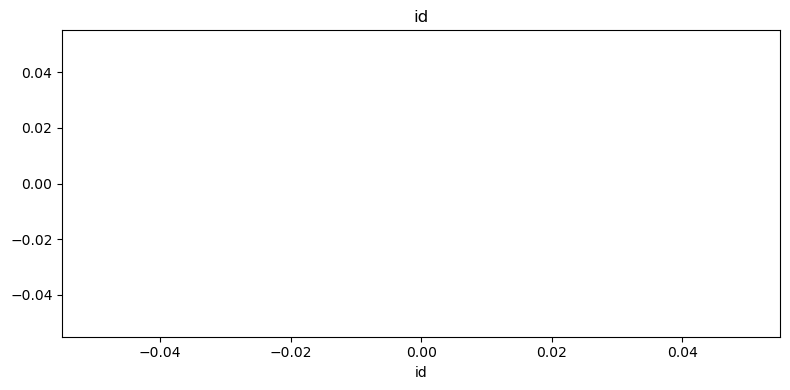

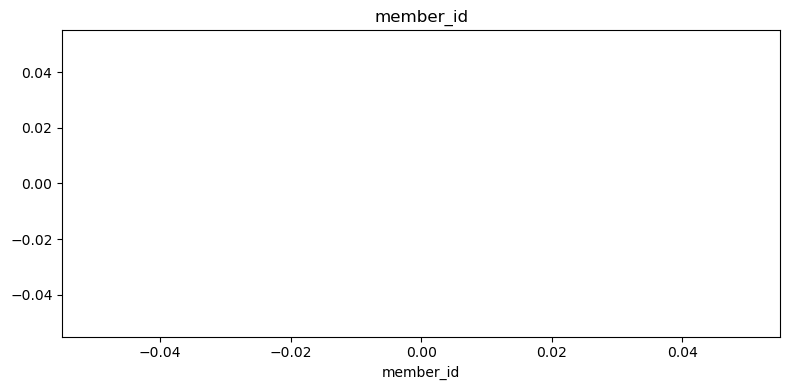

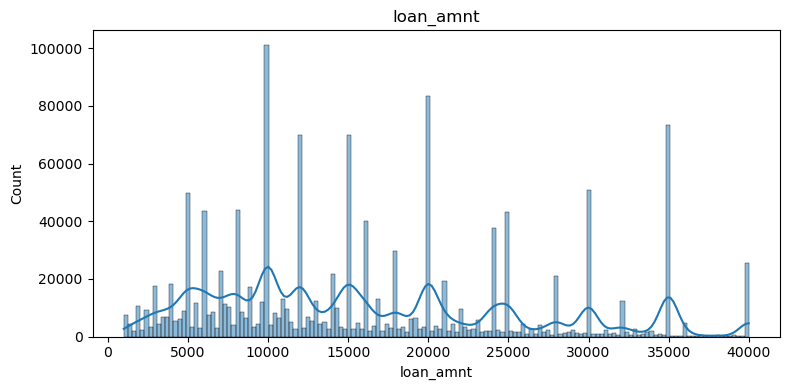

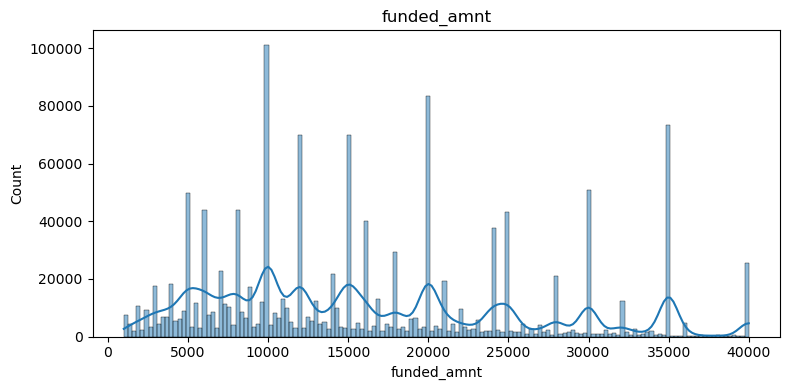

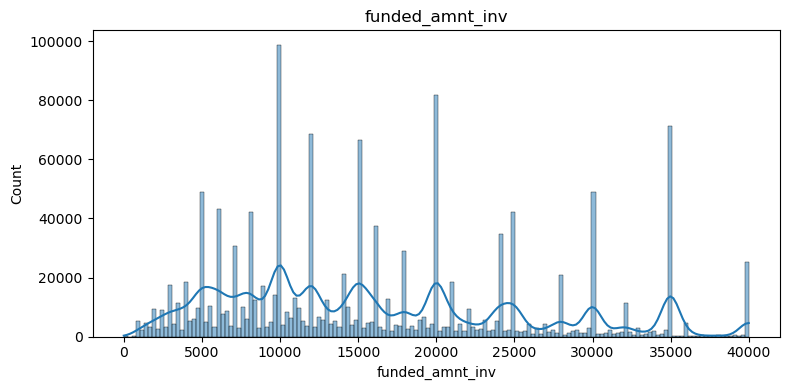

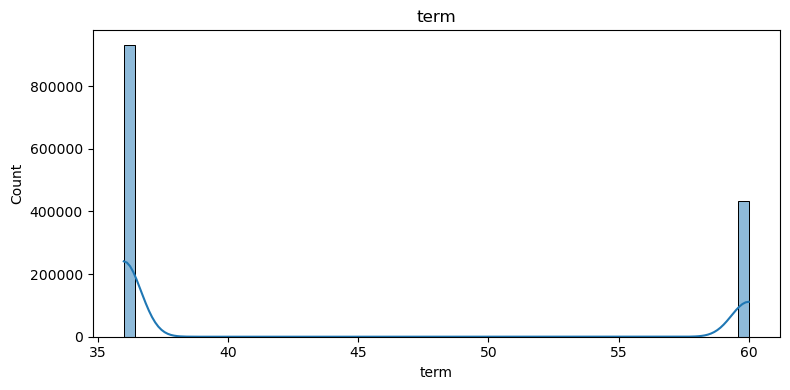

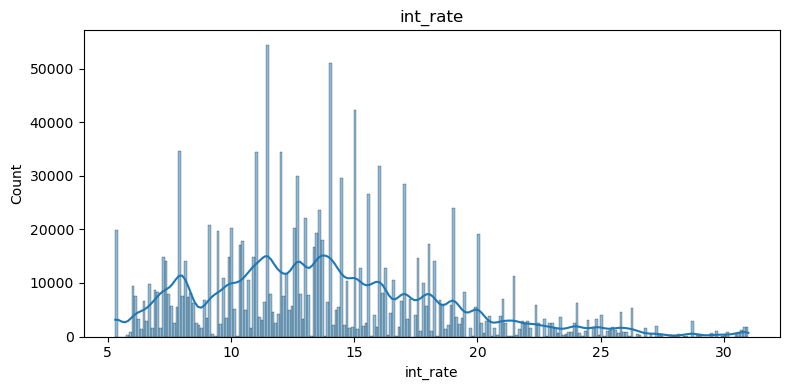

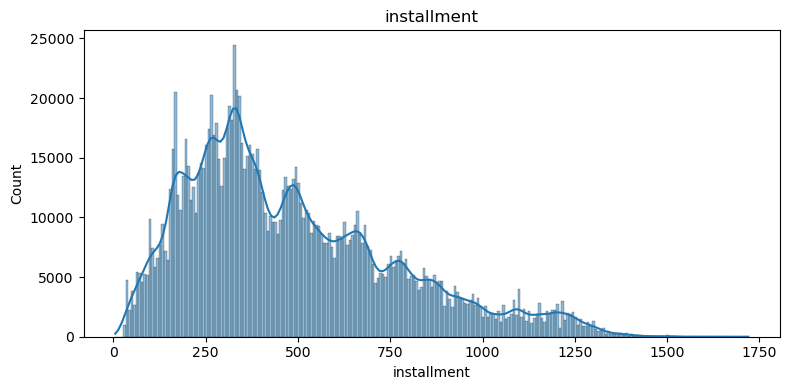

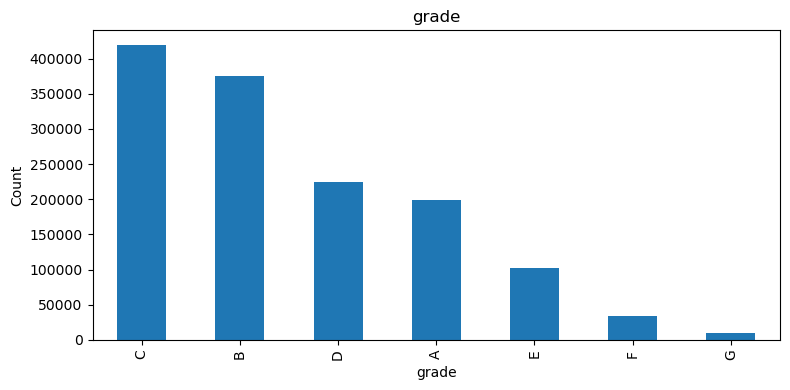

Skipping 'sub_grade' (too many categories: 35)
Skipping 'emp_title' (too many categories: 346387)


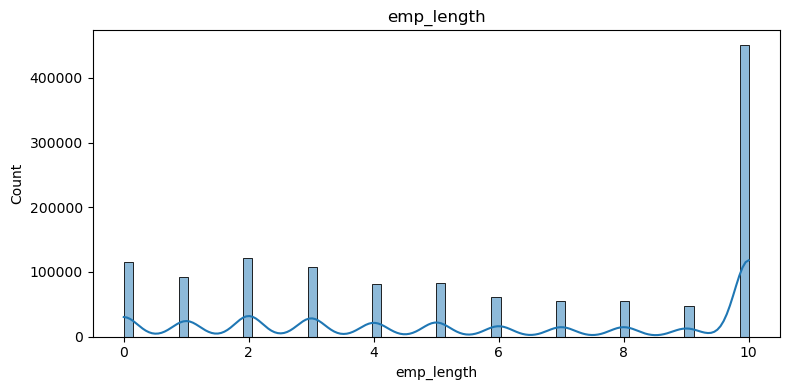

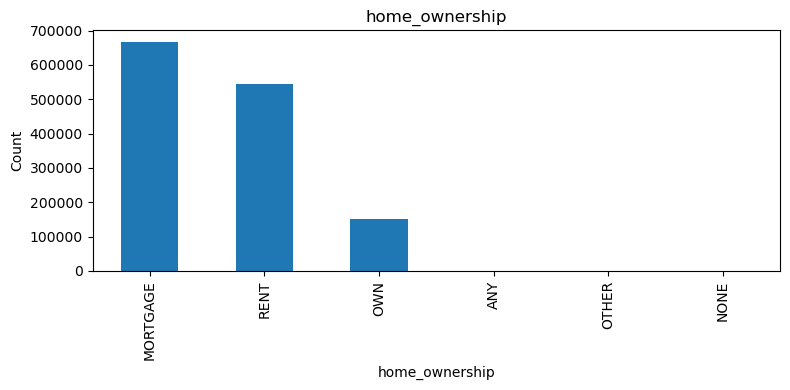

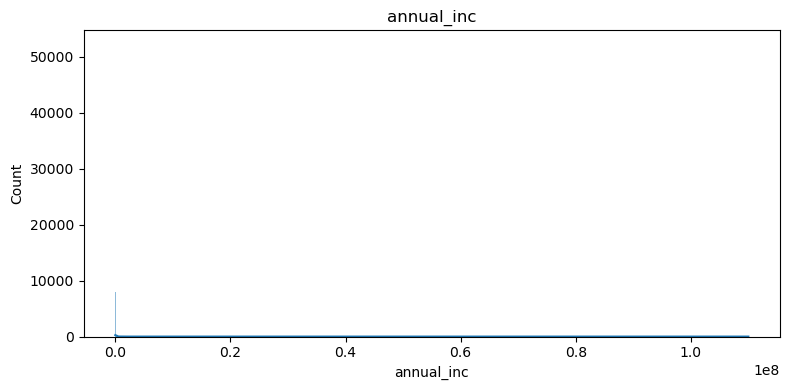

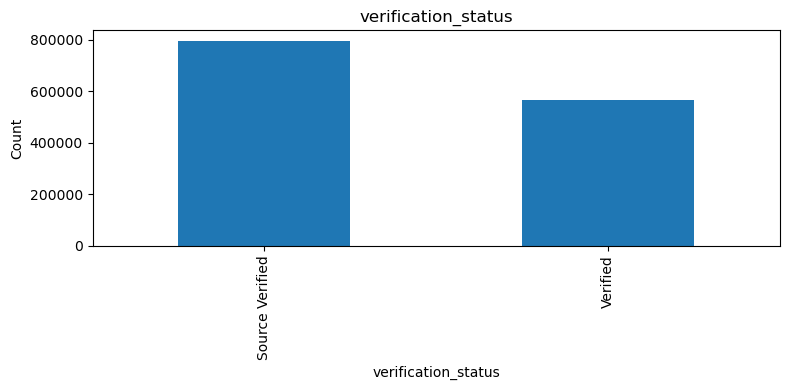

Skipping 'issue_d' (too many categories: 130)


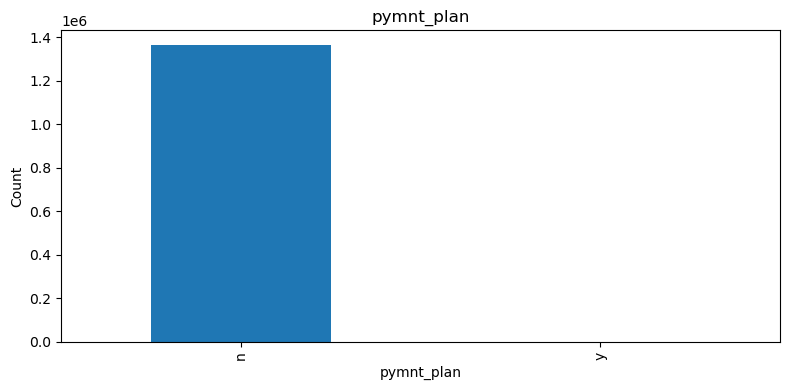

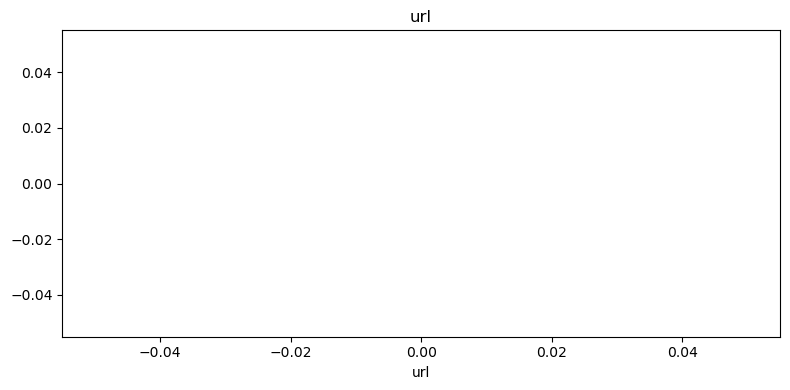

Skipping 'desc' (too many categories: 73044)


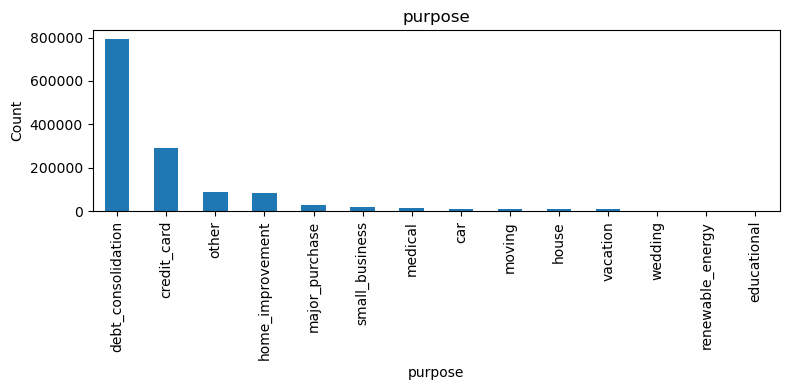

Skipping 'title' (too many categories: 38299)
Skipping 'zip_code' (too many categories: 941)
Skipping 'addr_state' (too many categories: 51)


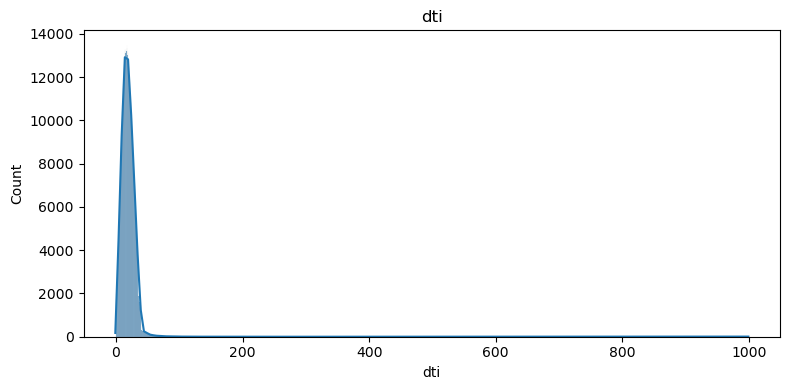

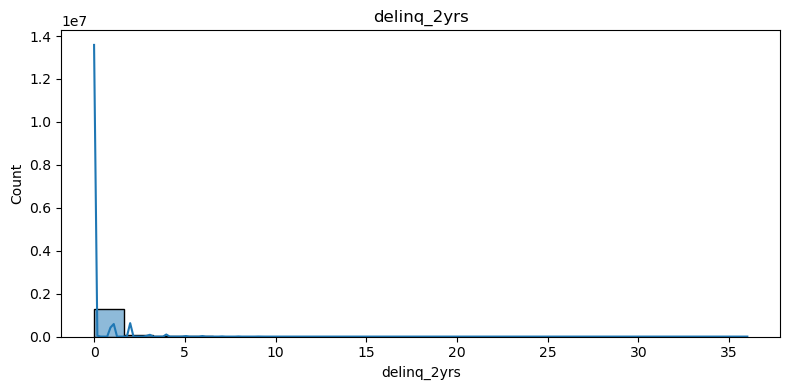

Skipping 'earliest_cr_line' (too many categories: 736)


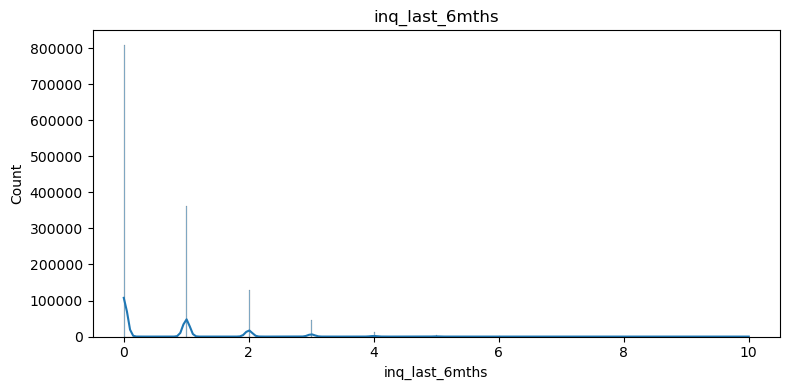

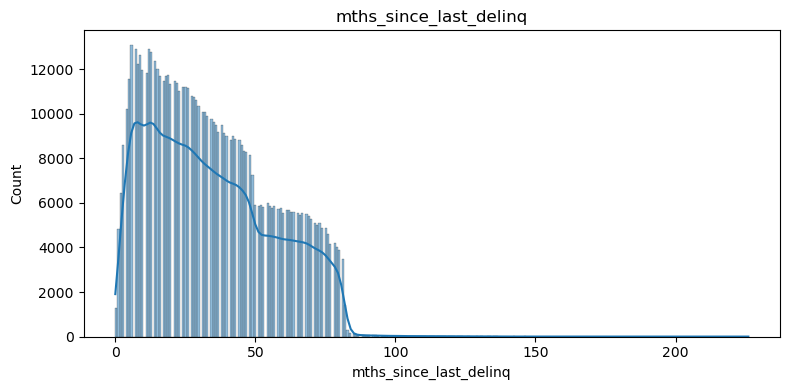

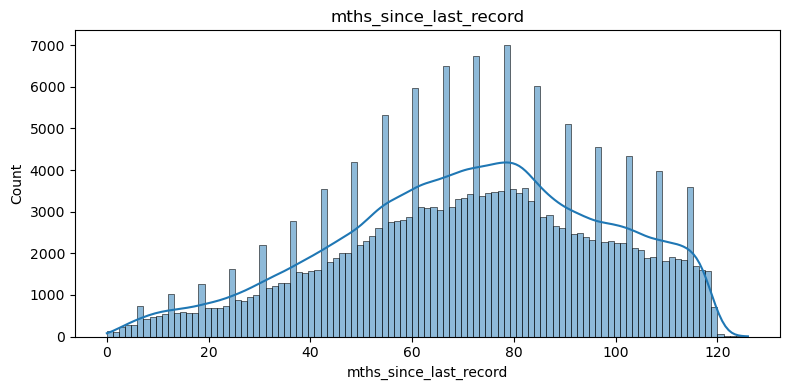

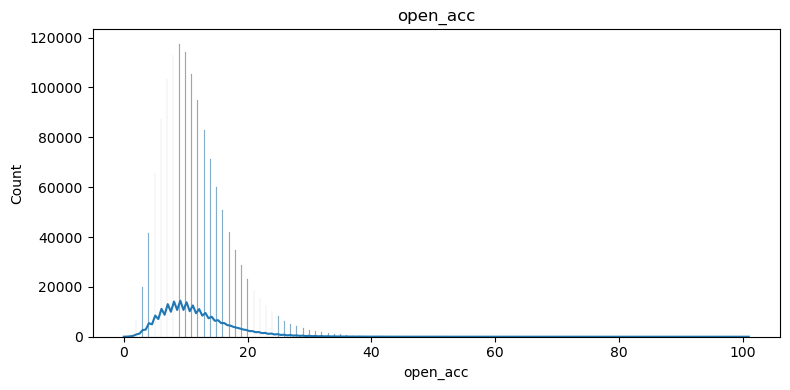

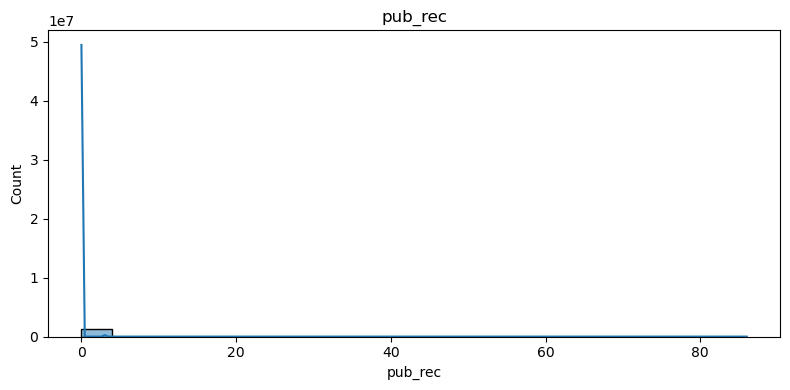

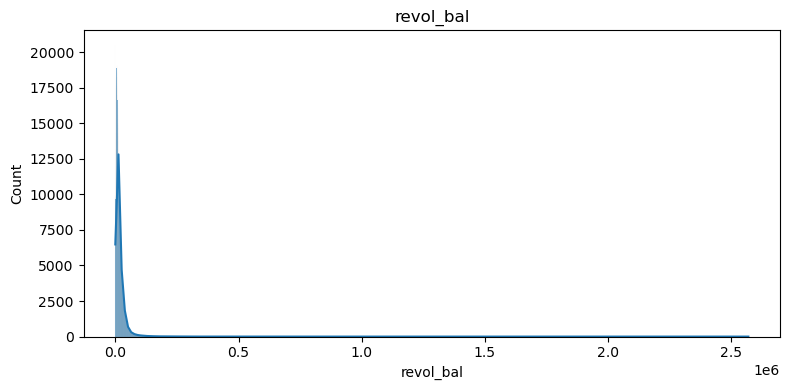

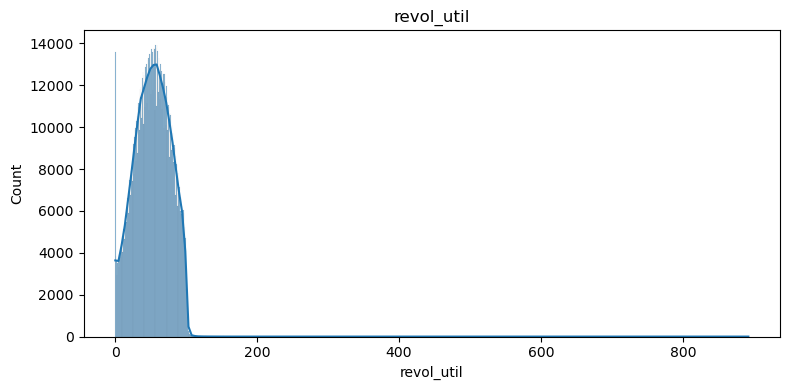

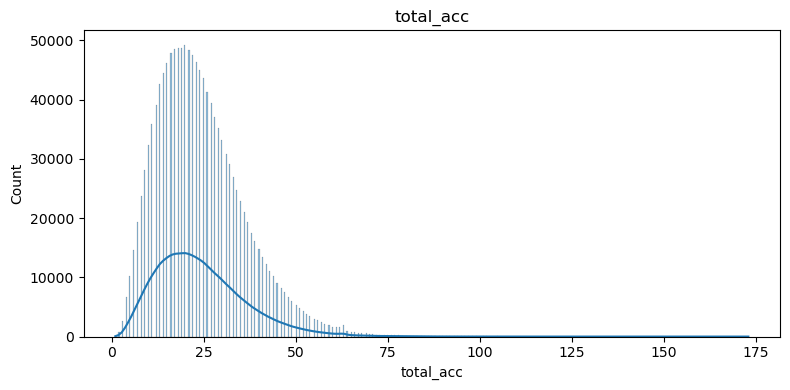

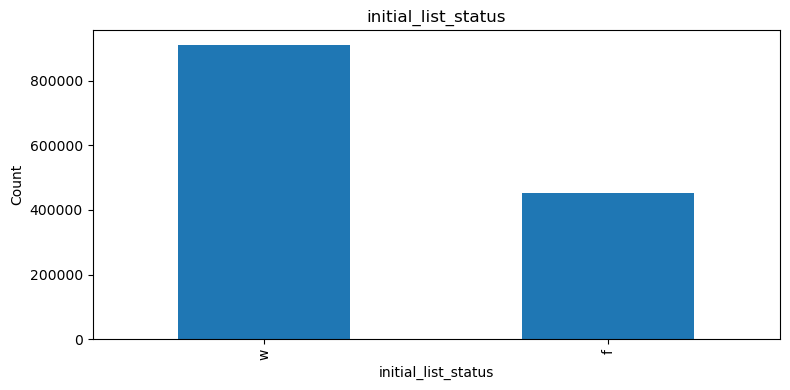

Skipping 'last_credit_pull_d' (too many categories: 124)


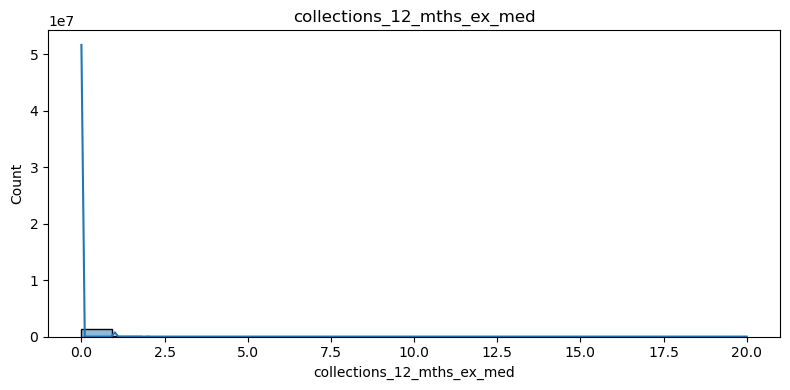

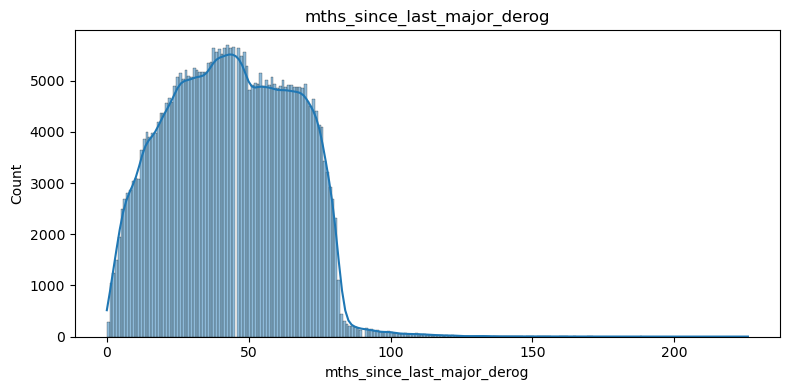

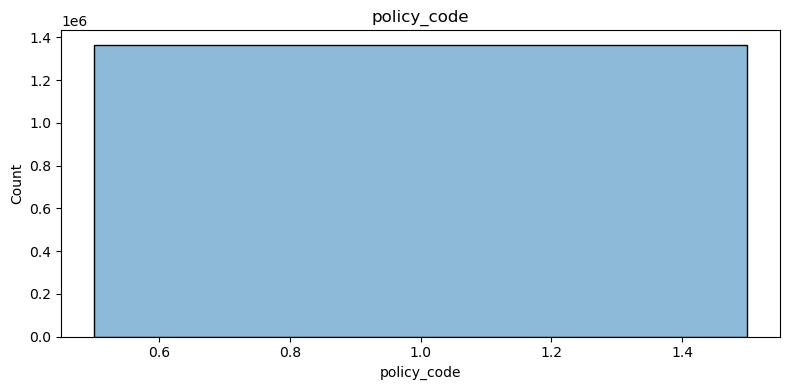

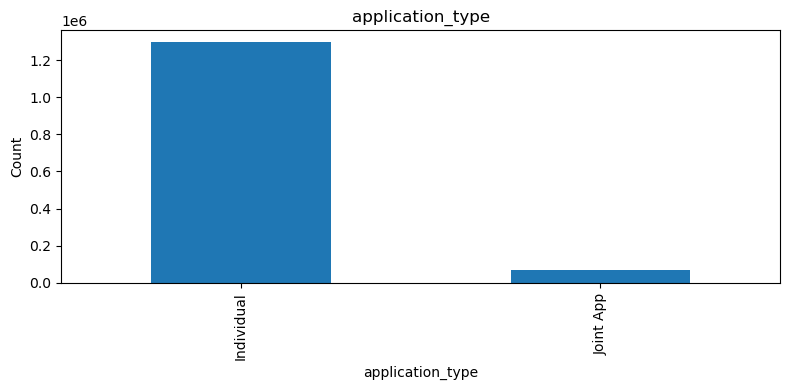

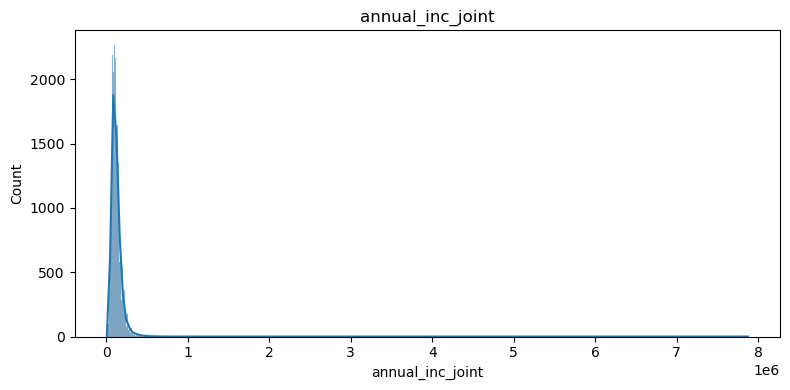

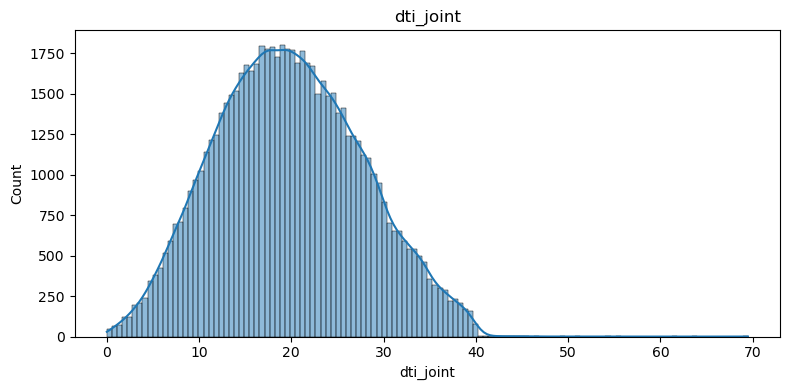

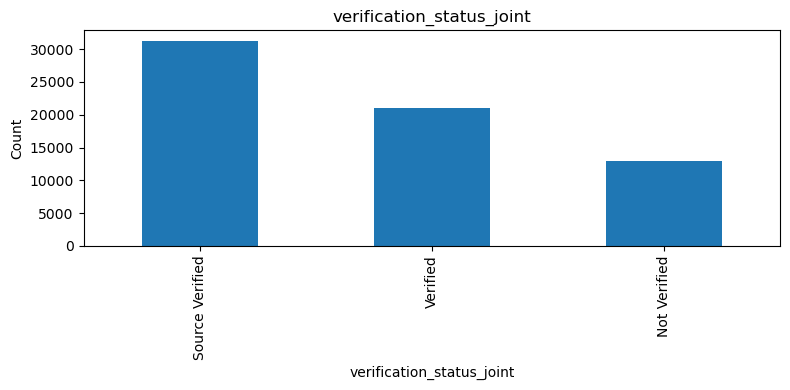

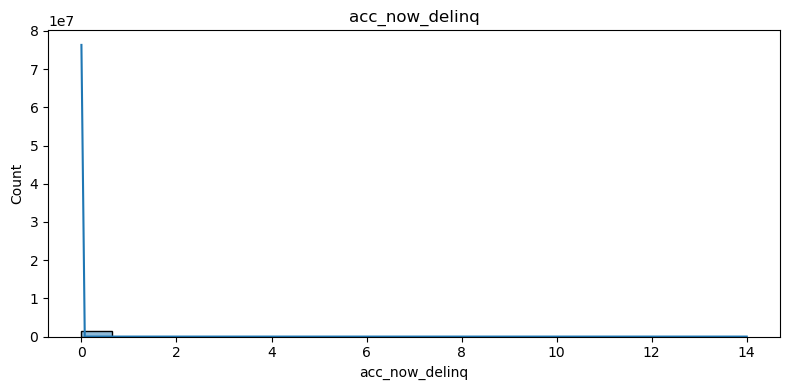

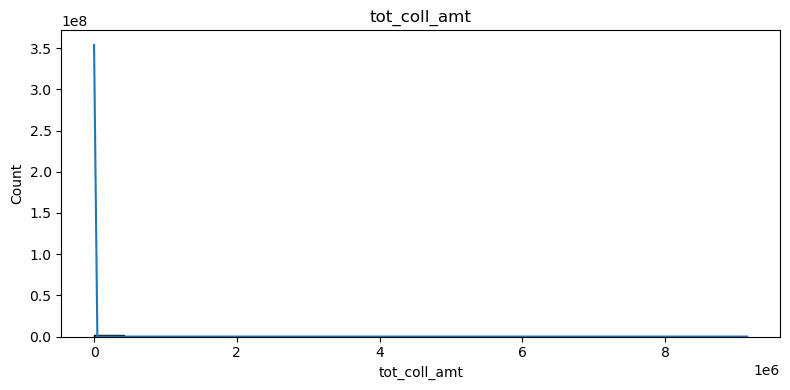

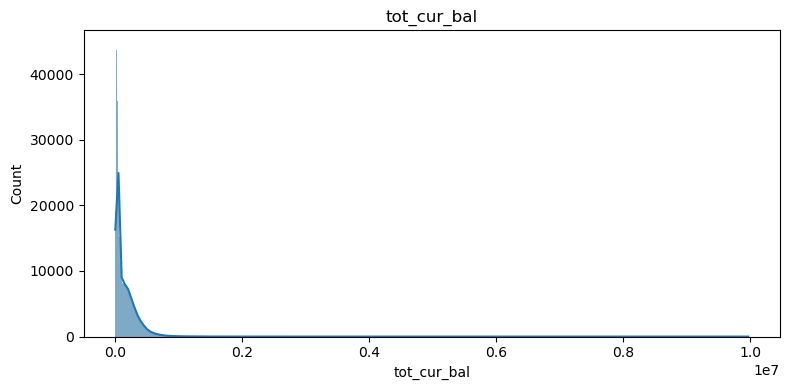

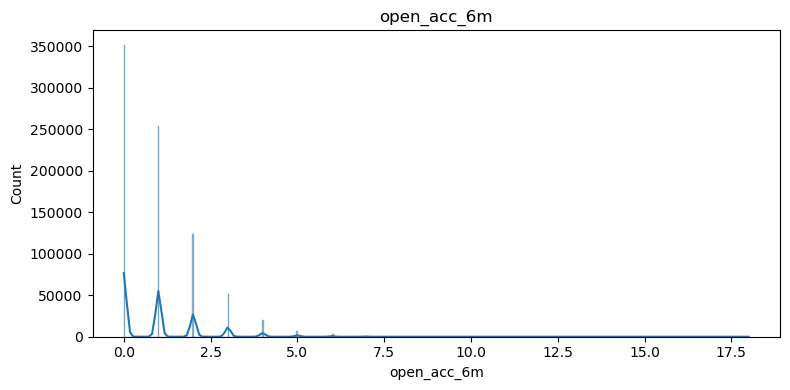

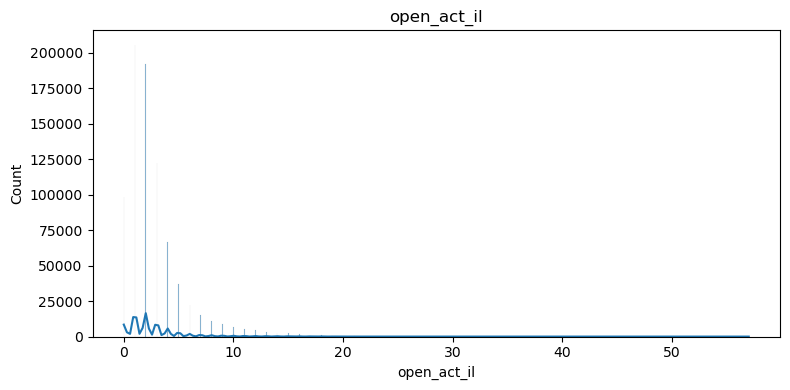

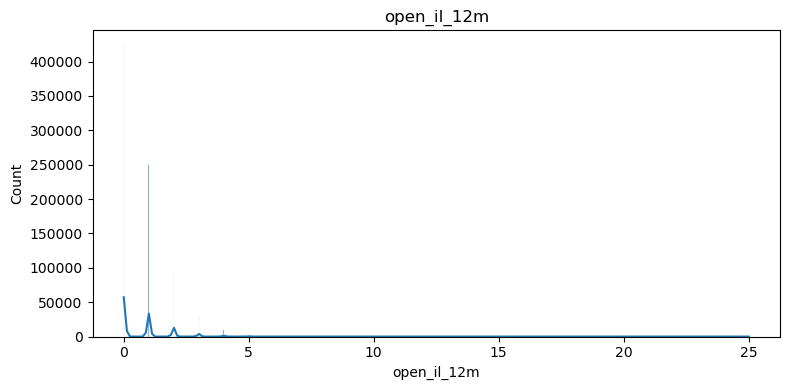

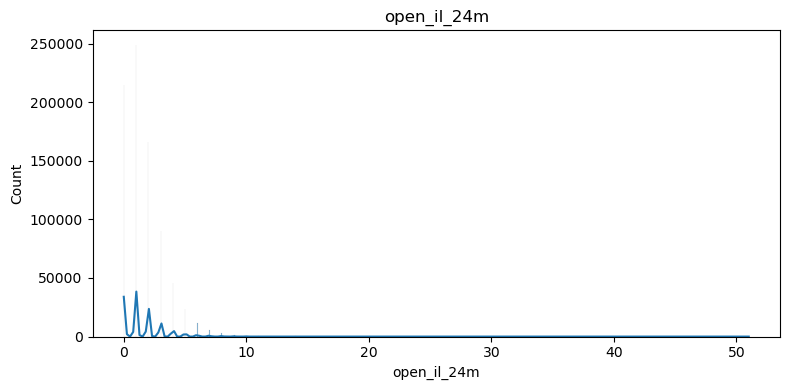

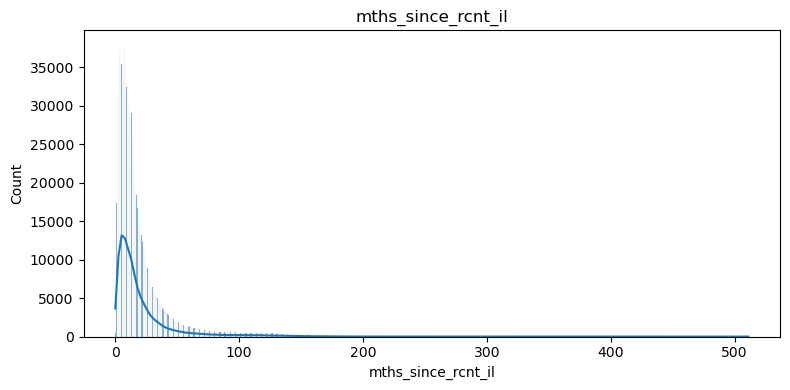

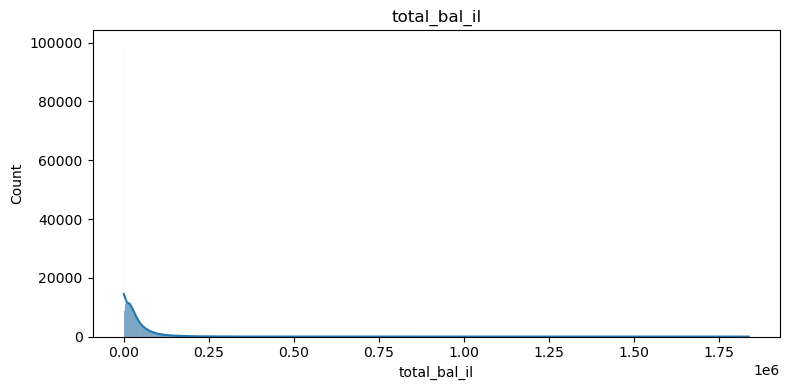

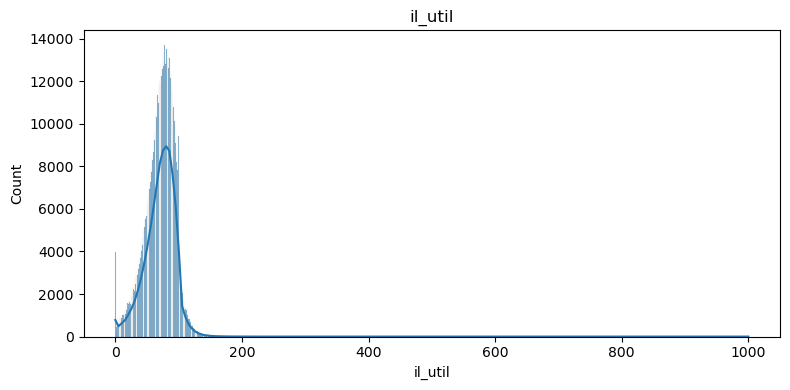

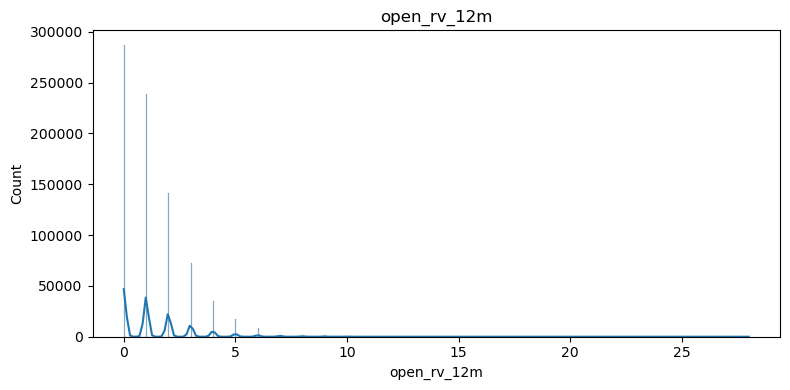

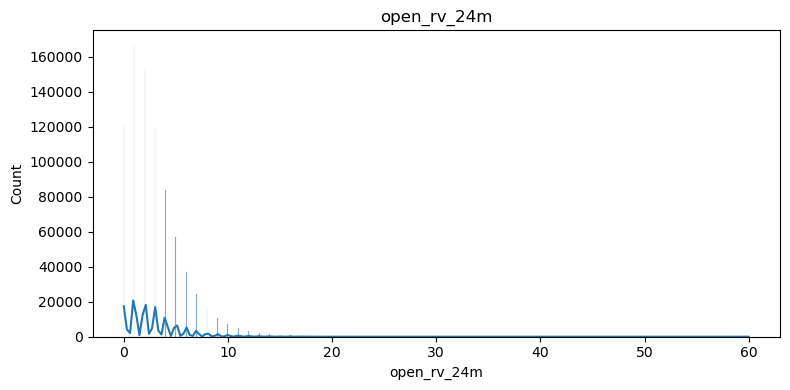

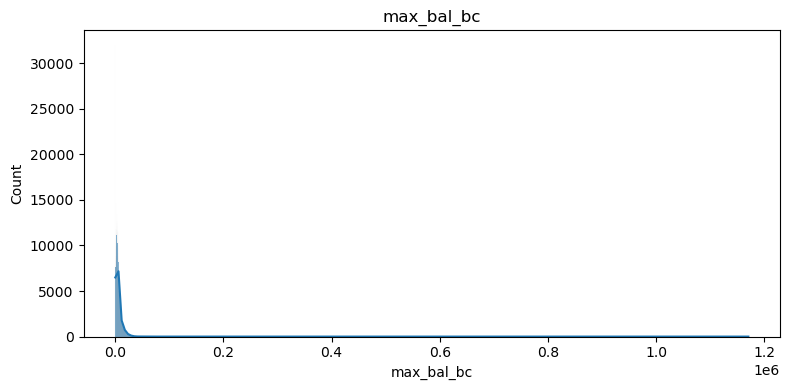

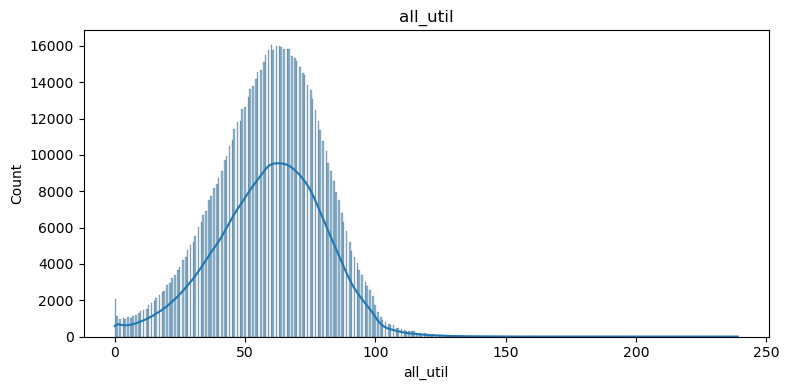

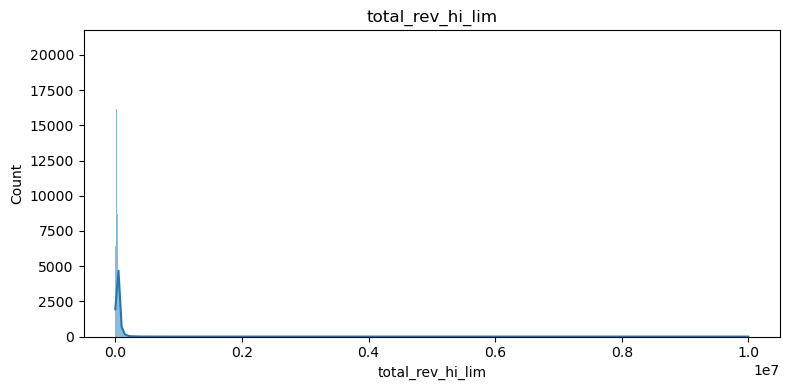

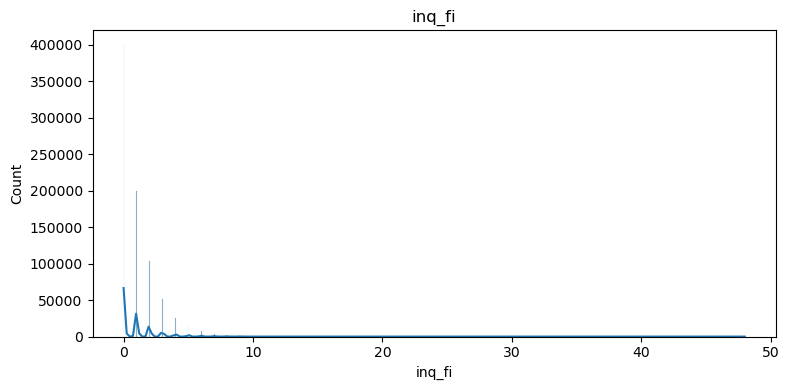

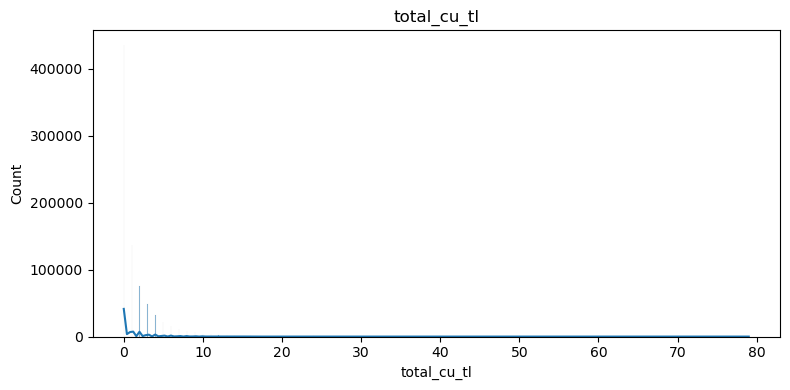

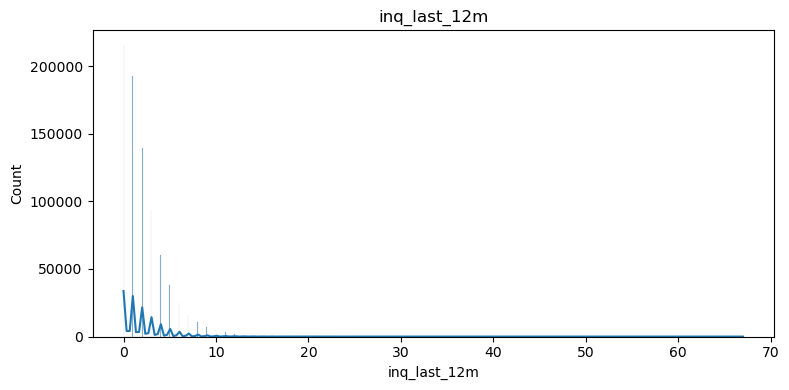

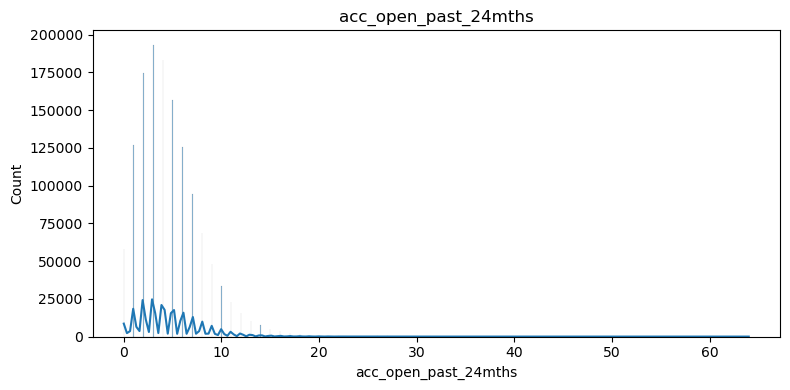

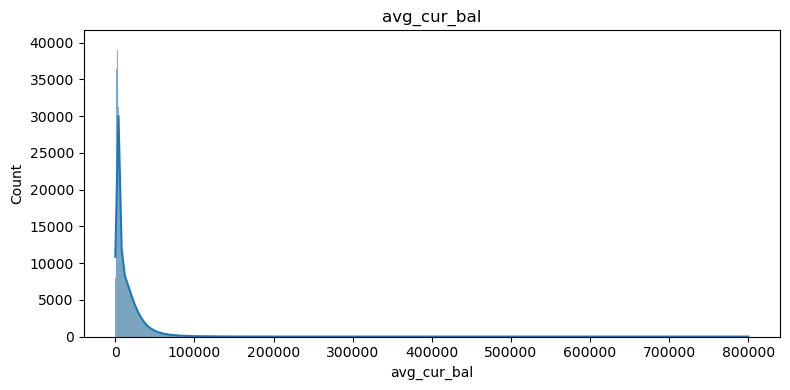

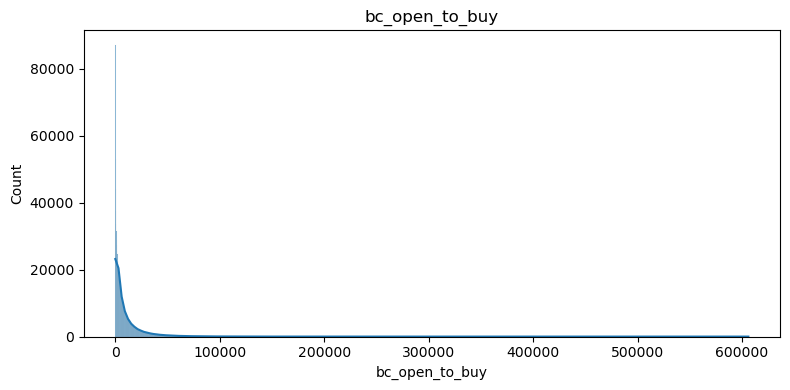

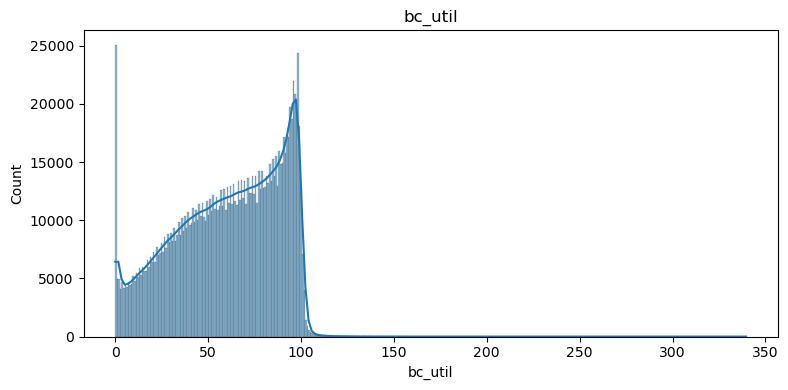

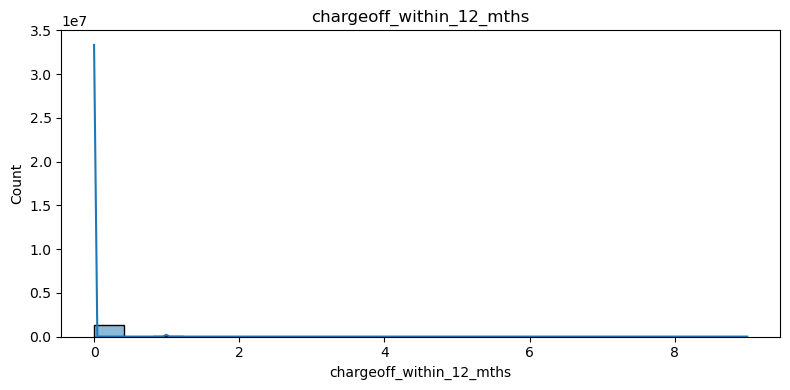

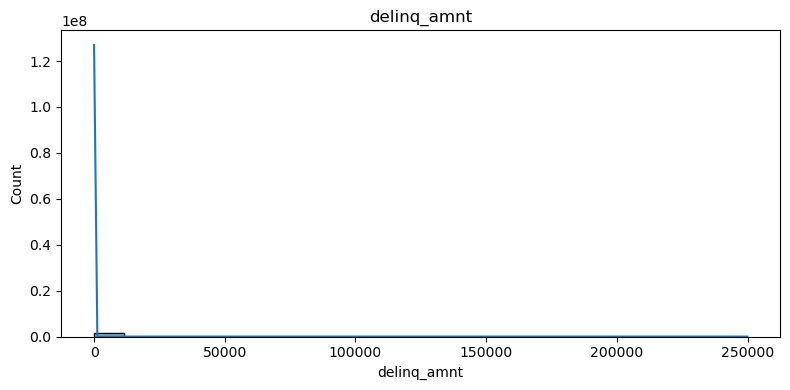

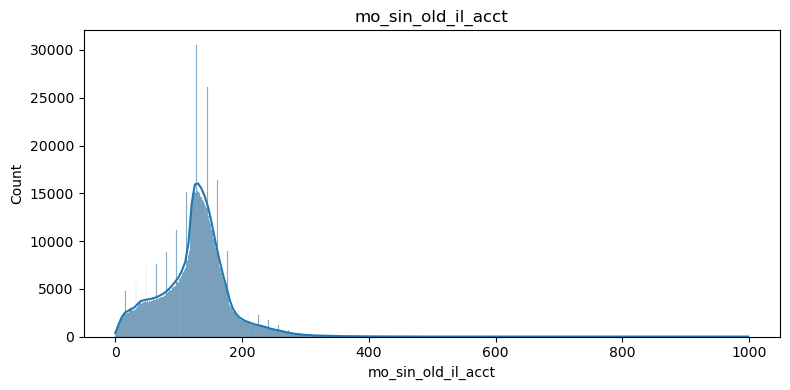

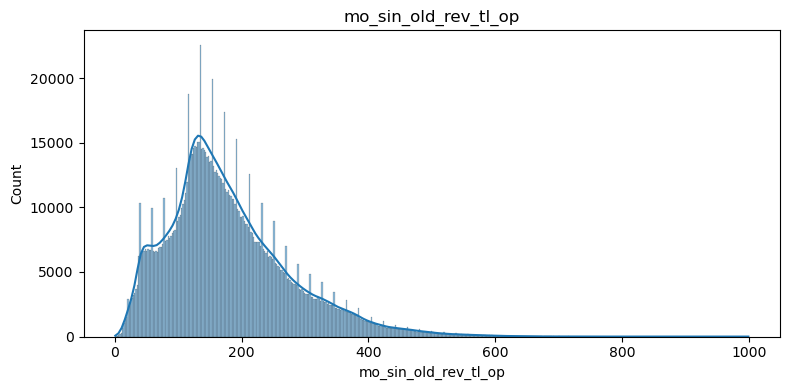

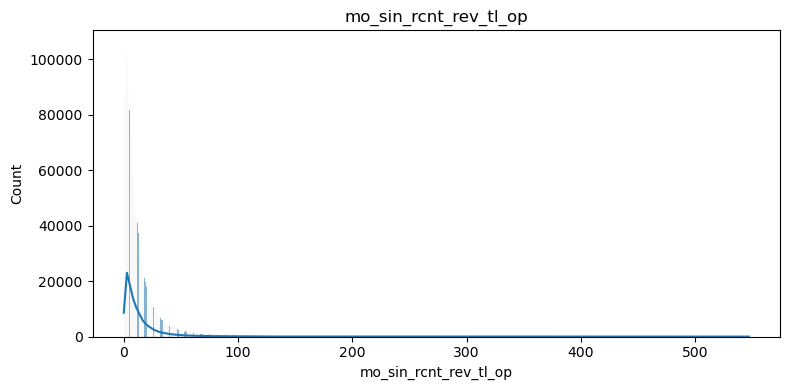

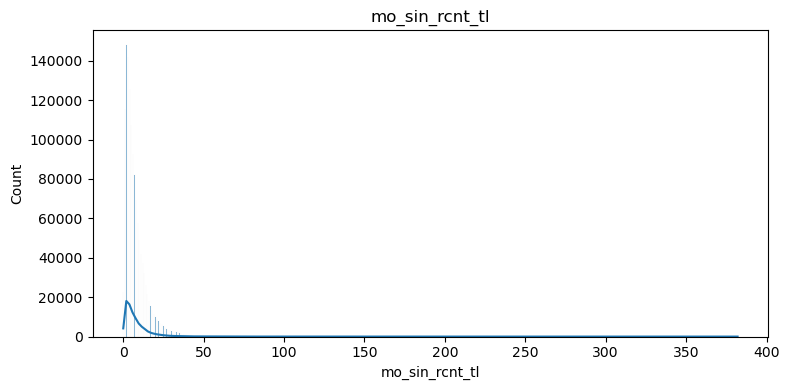

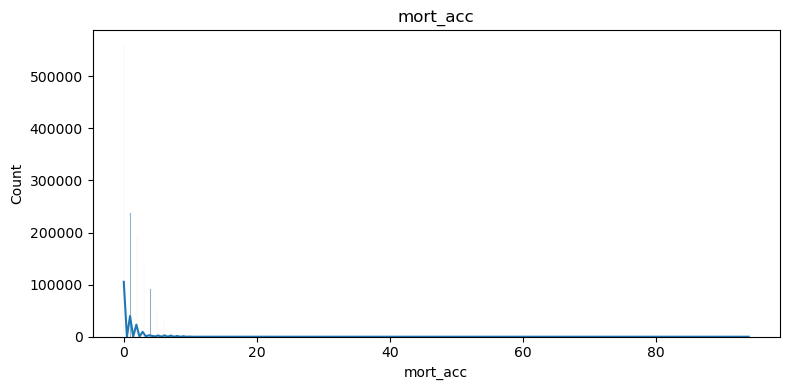

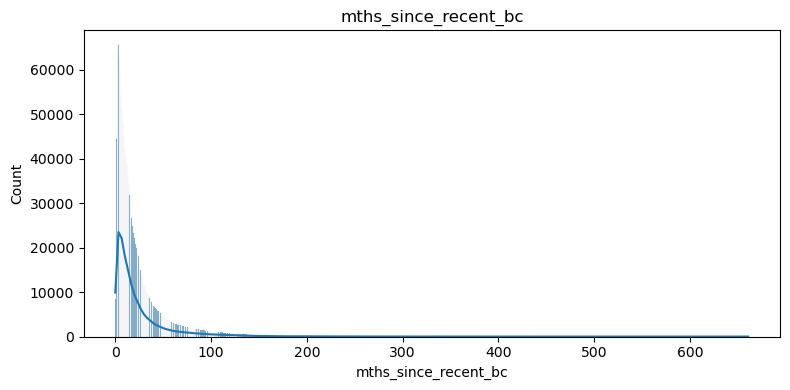

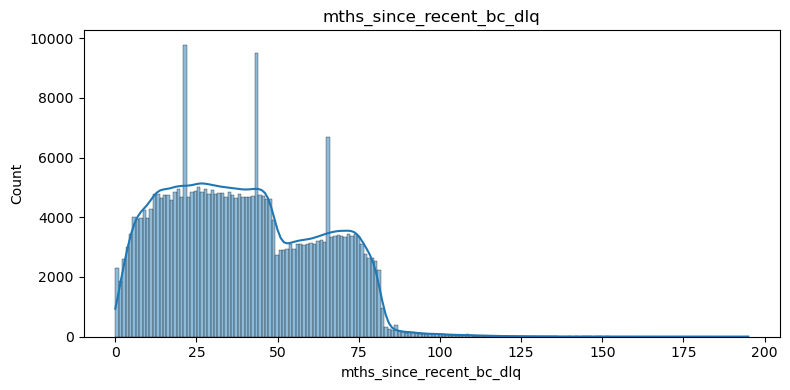

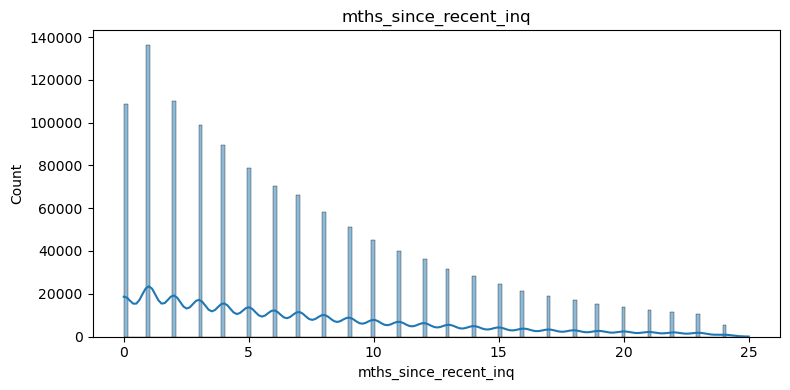

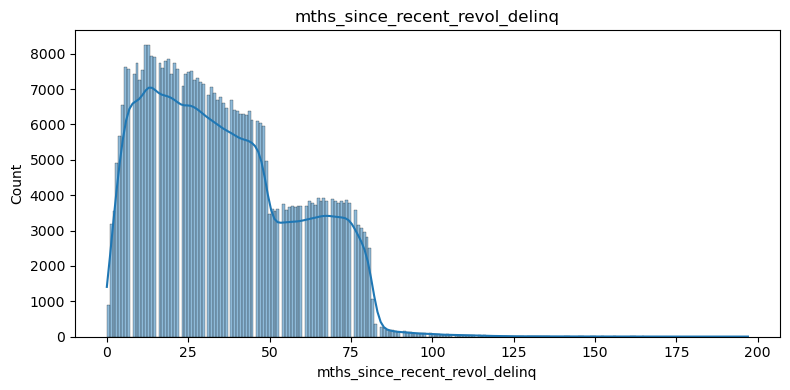

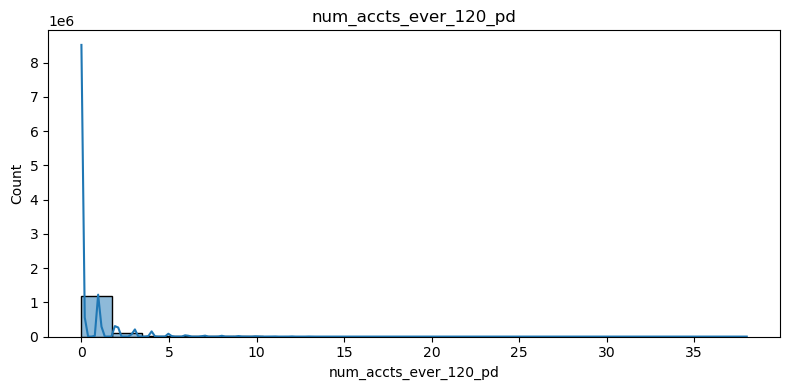

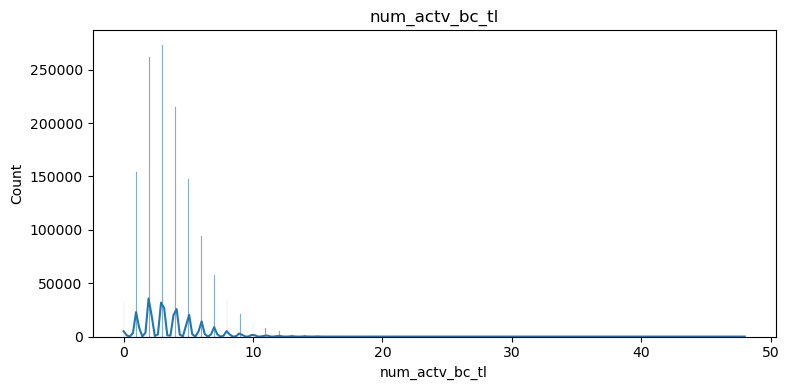

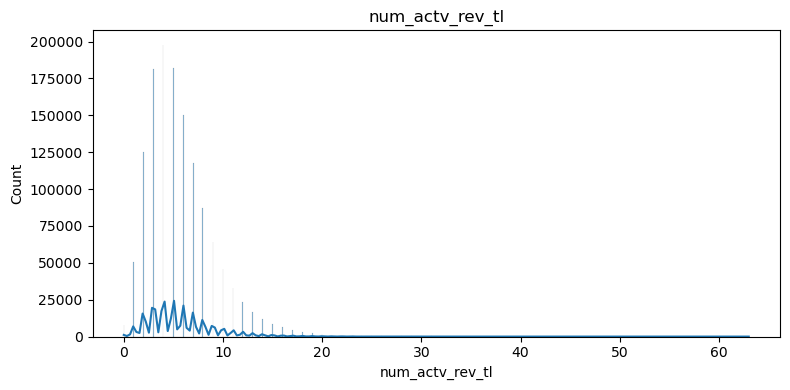

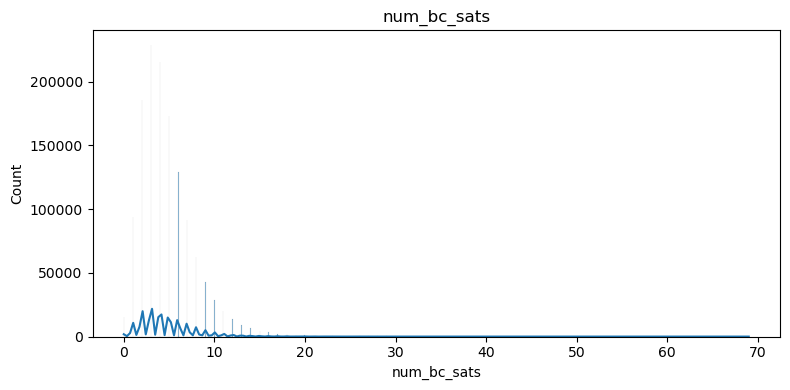

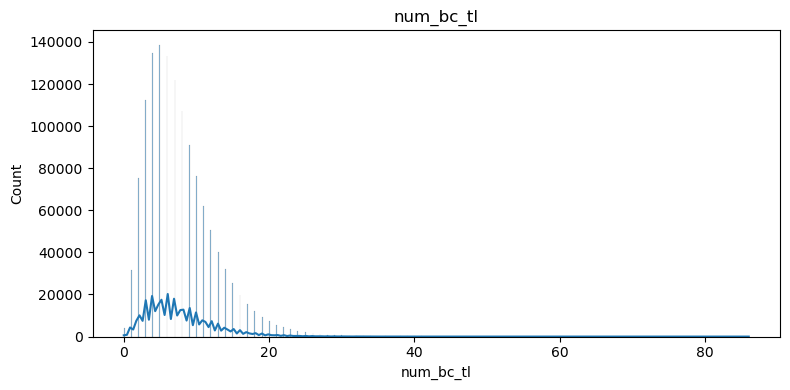

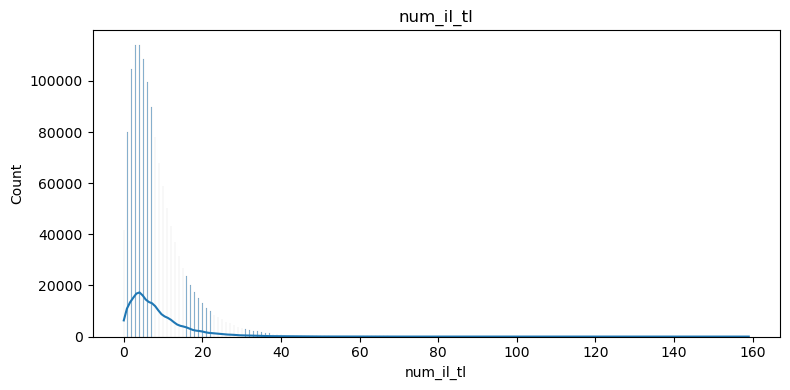

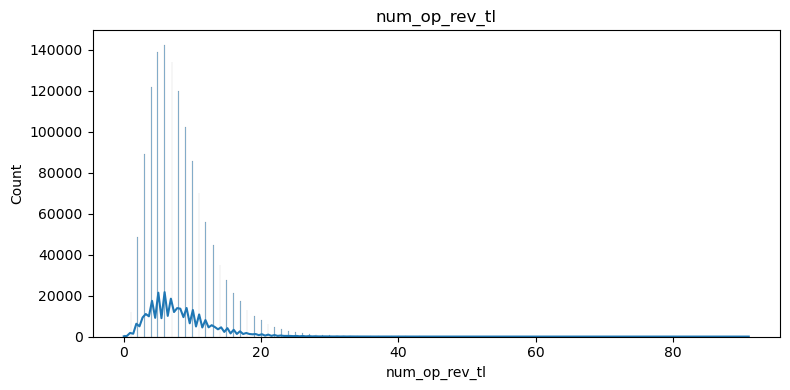

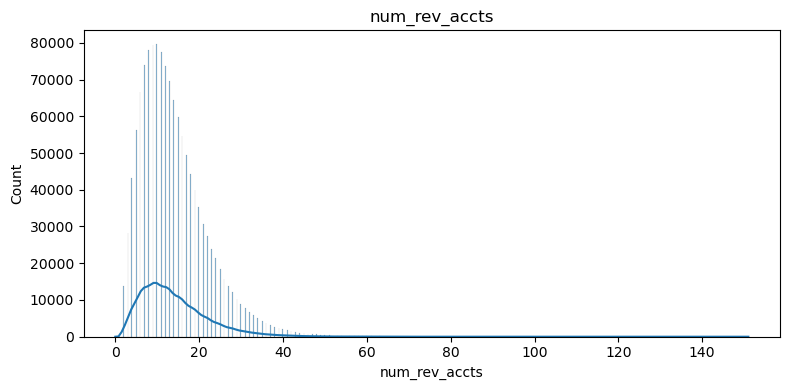

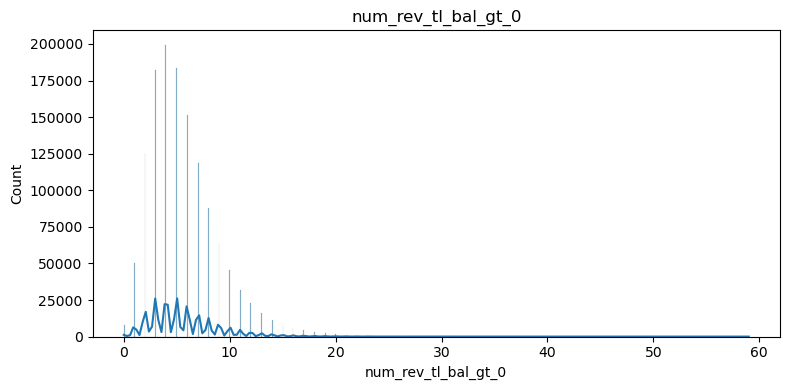

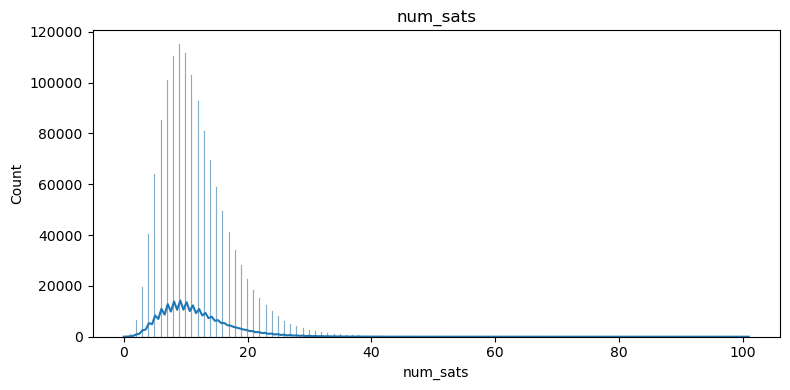

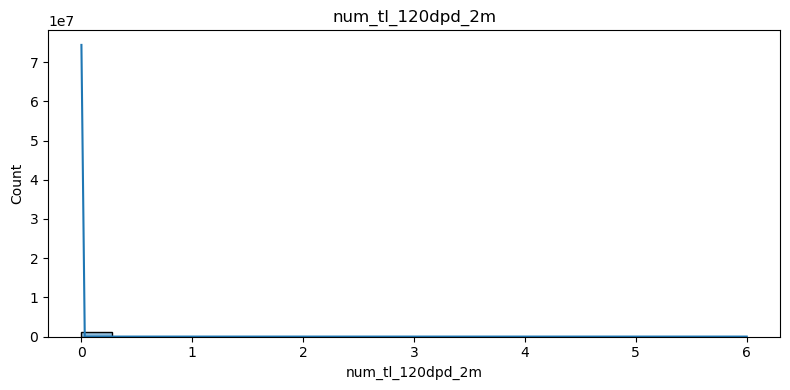

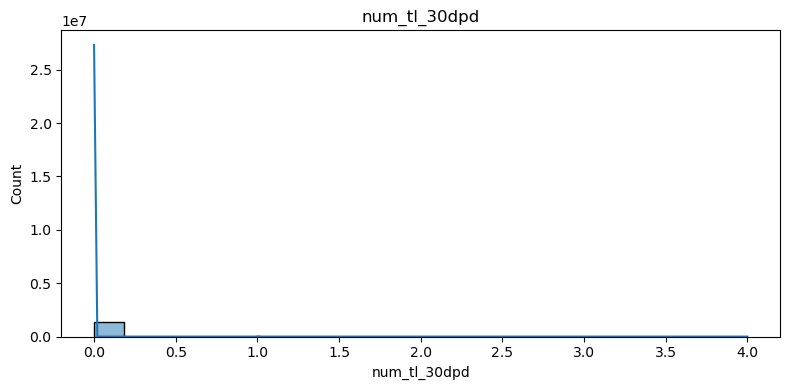

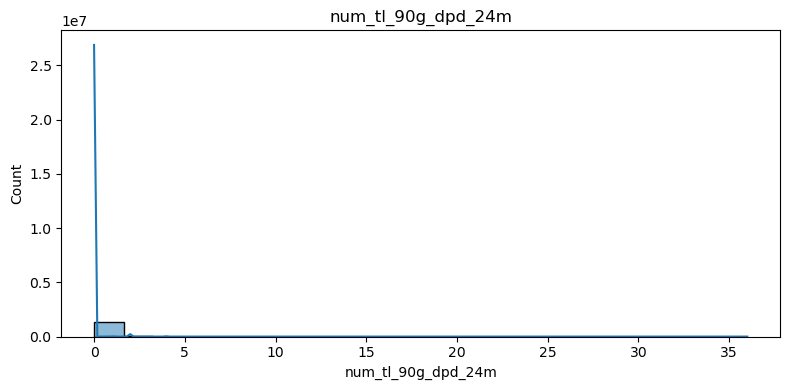

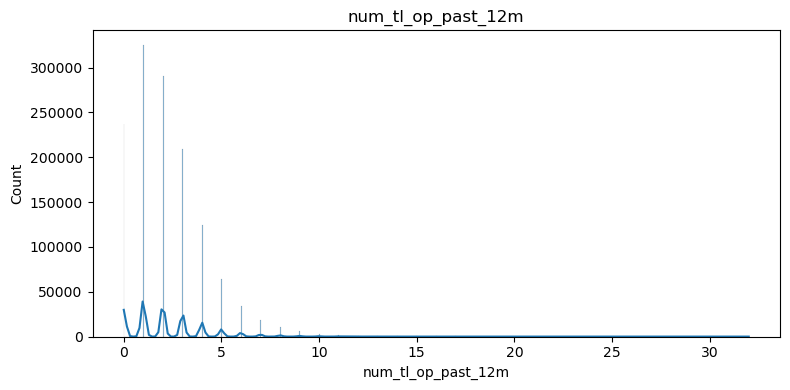

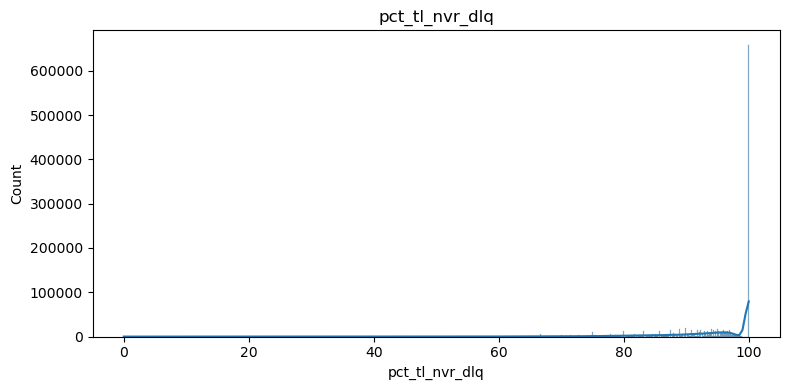

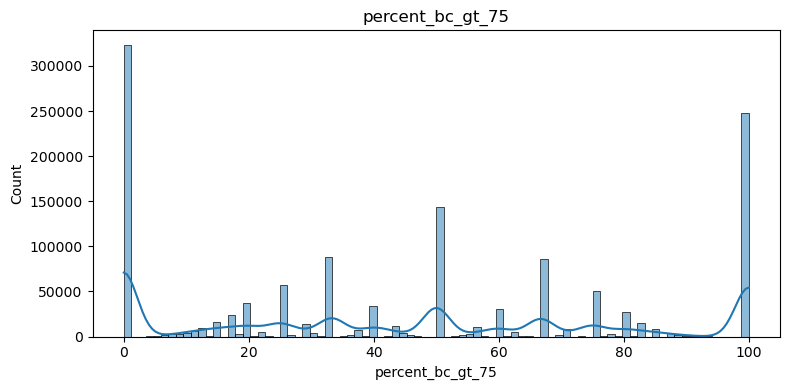

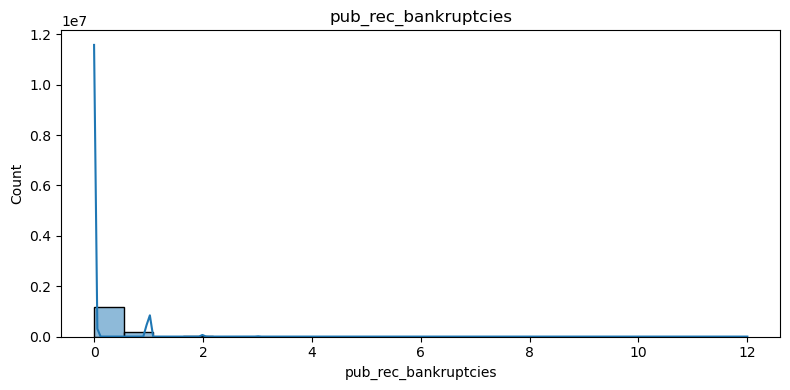

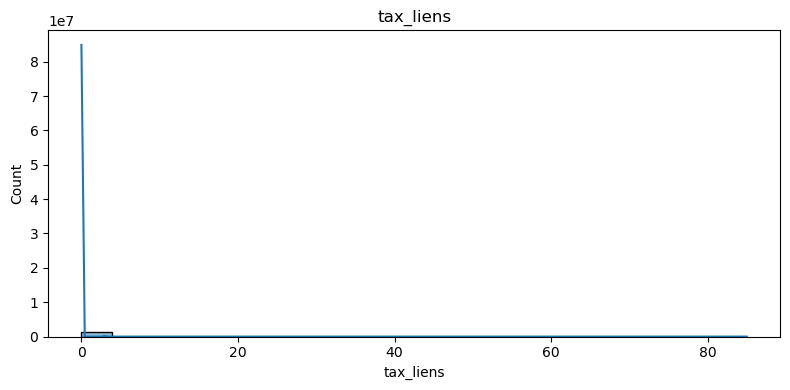

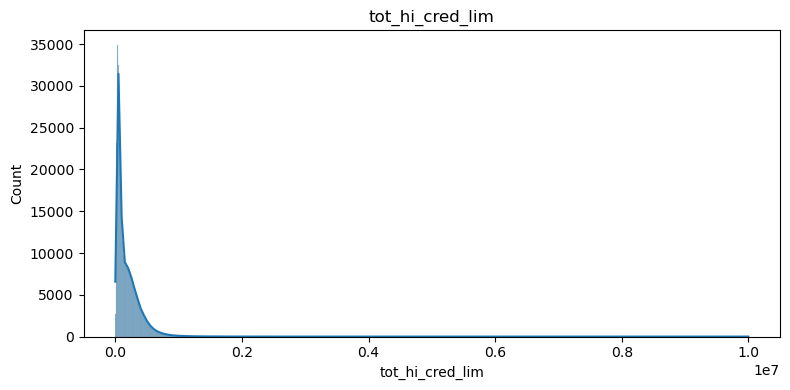

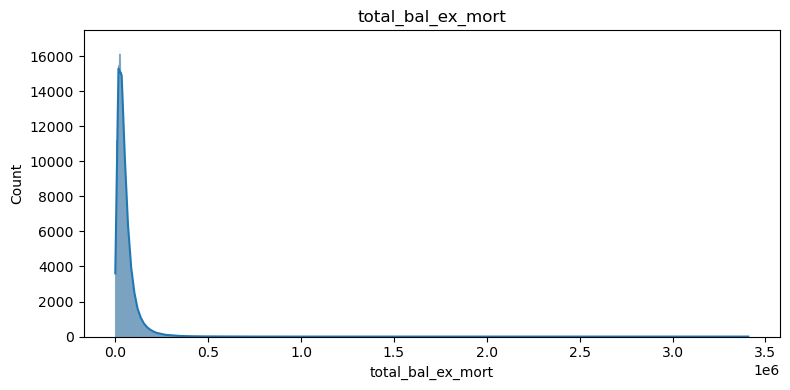

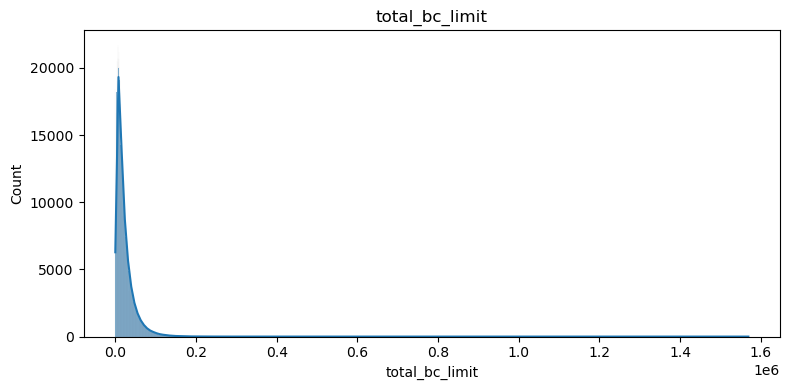

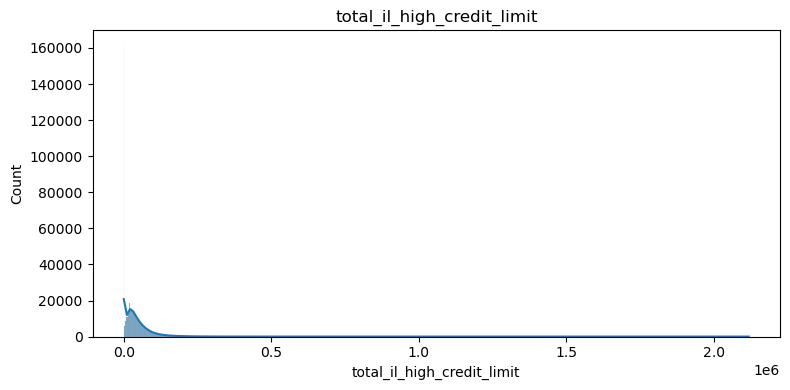

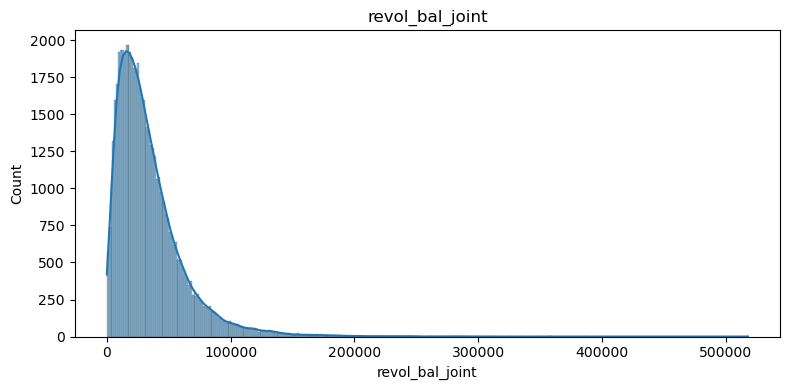

Skipping 'sec_app_earliest_cr_line' (too many categories: 635)


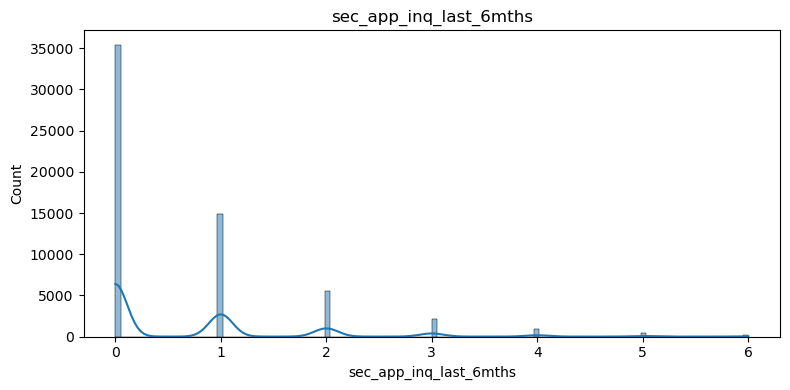

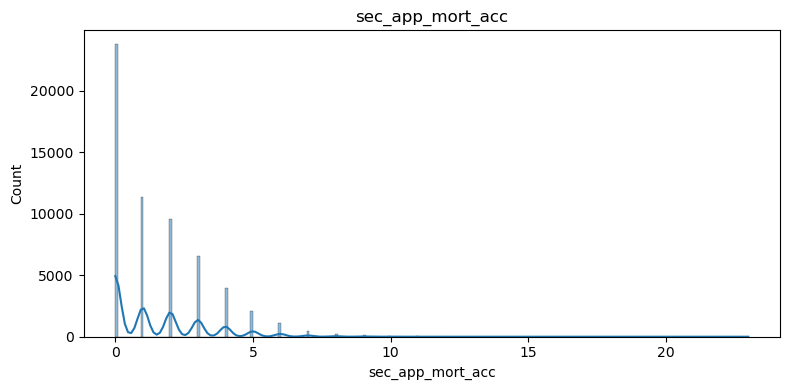

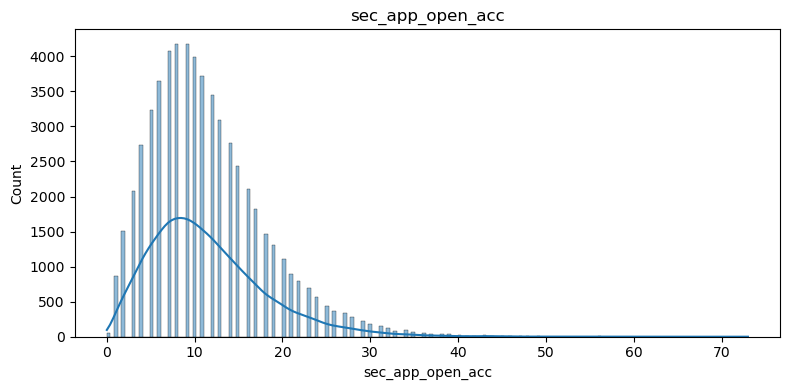

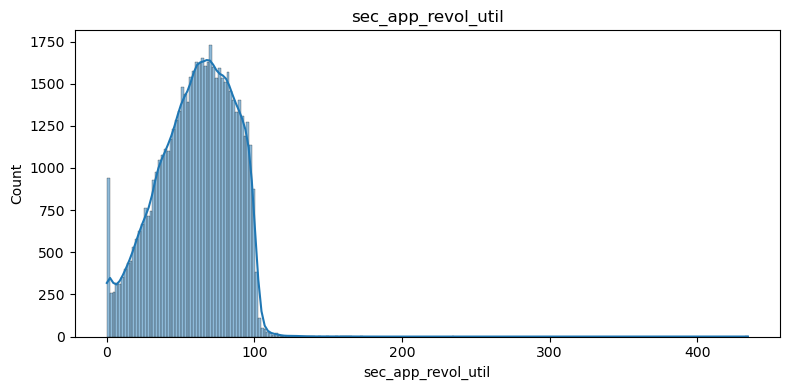

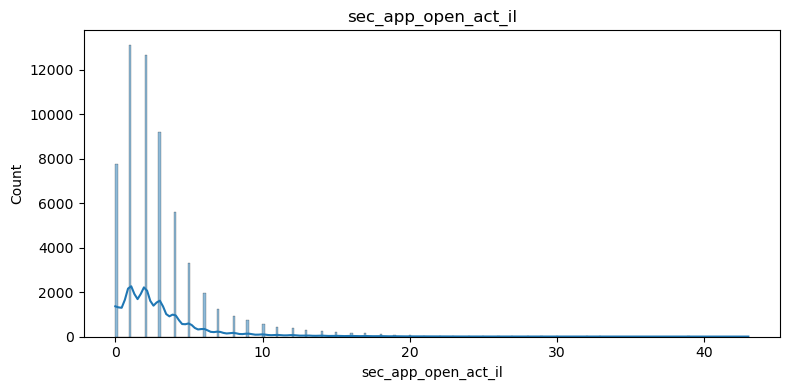

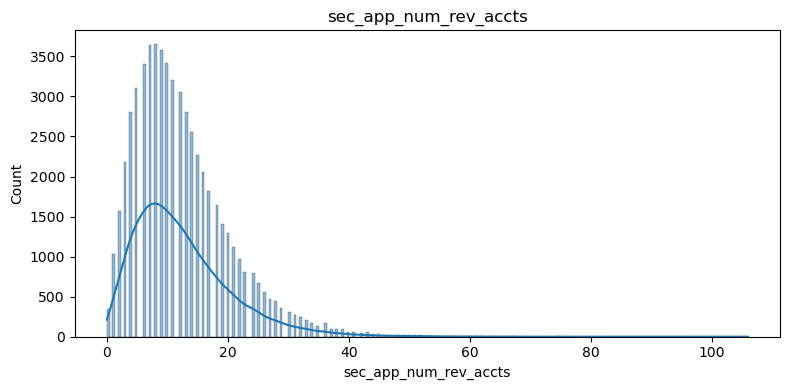

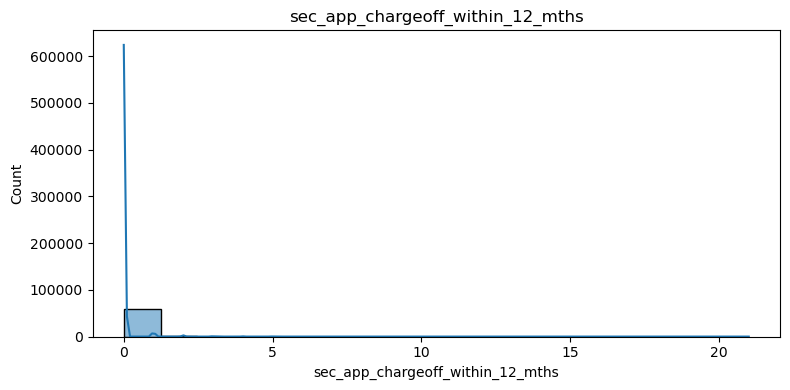

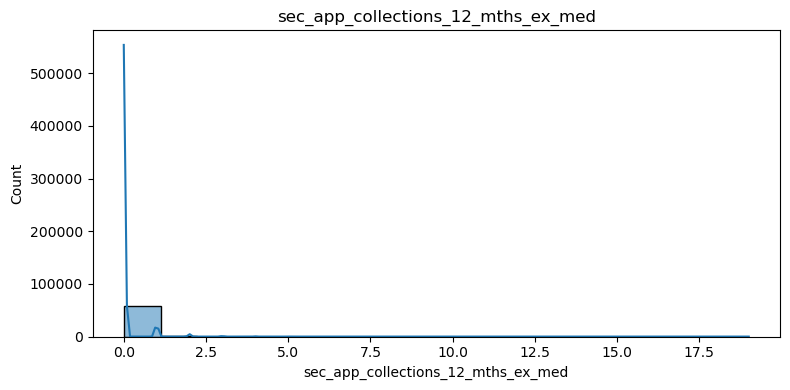

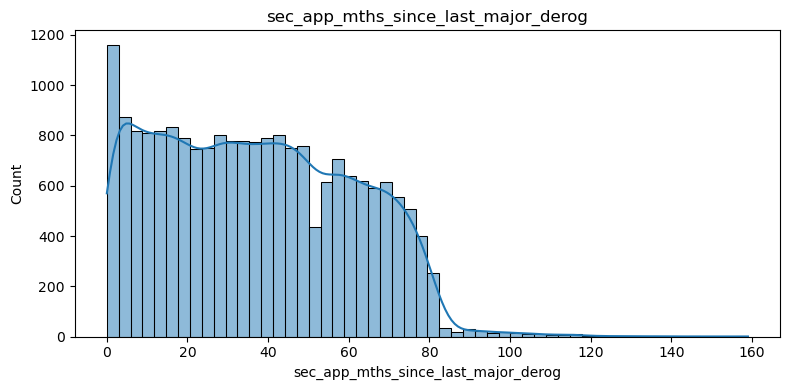

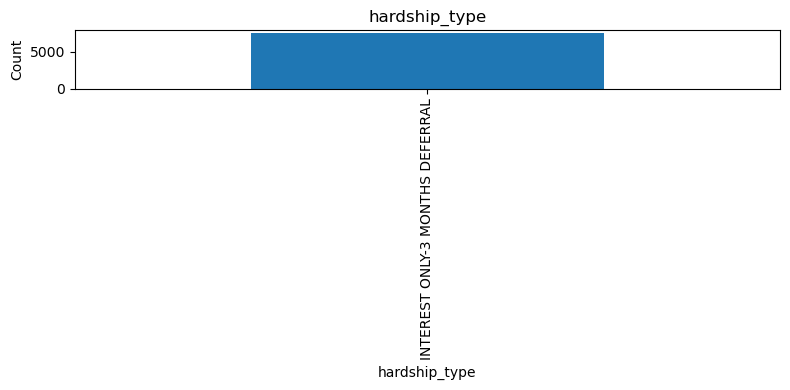

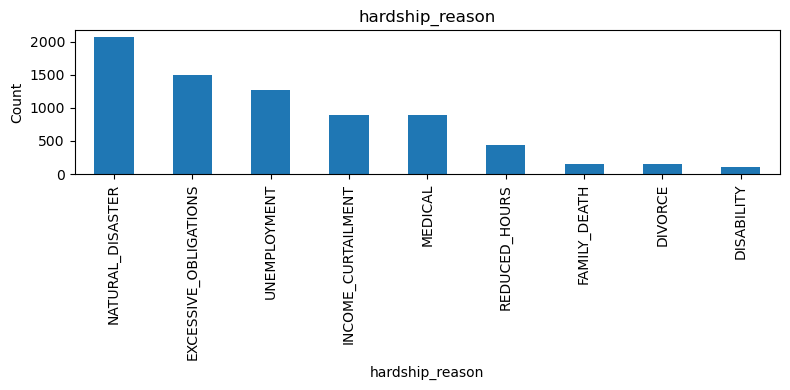

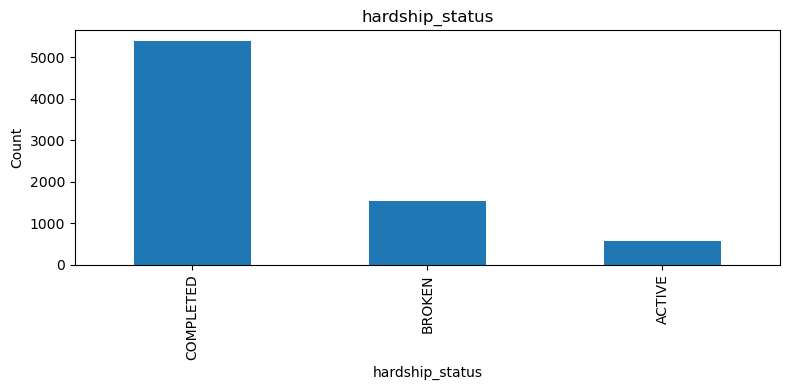

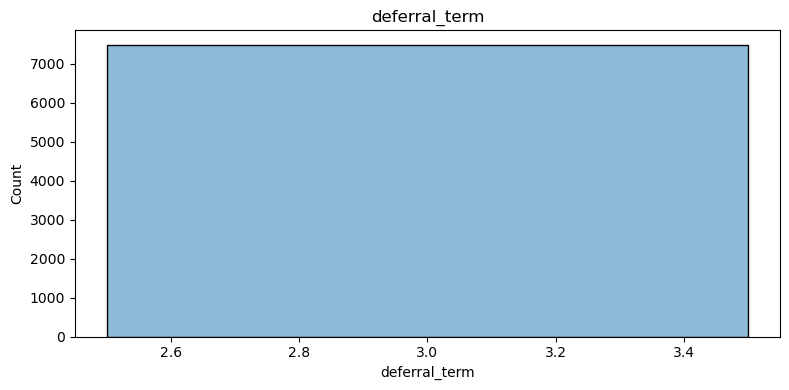

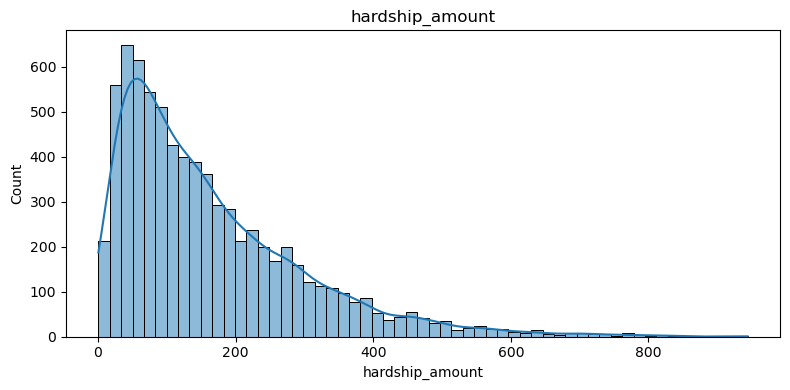

Skipping 'hardship_start_date' (too many categories: 26)
Skipping 'hardship_end_date' (too many categories: 27)
Skipping 'payment_plan_start_date' (too many categories: 26)


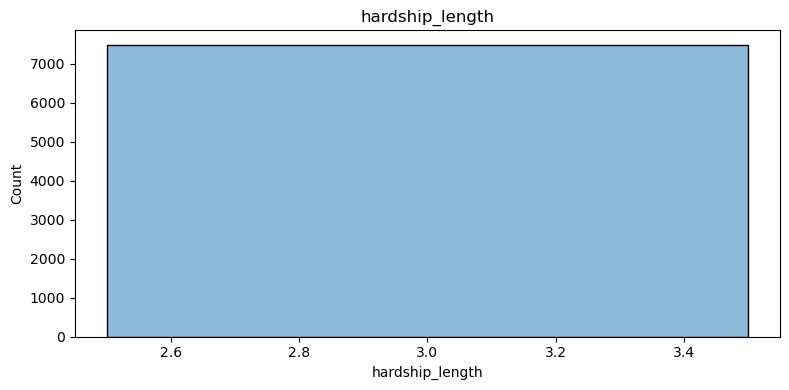

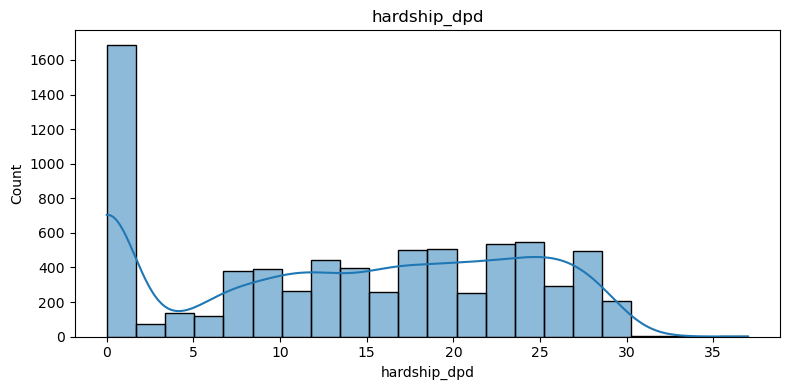

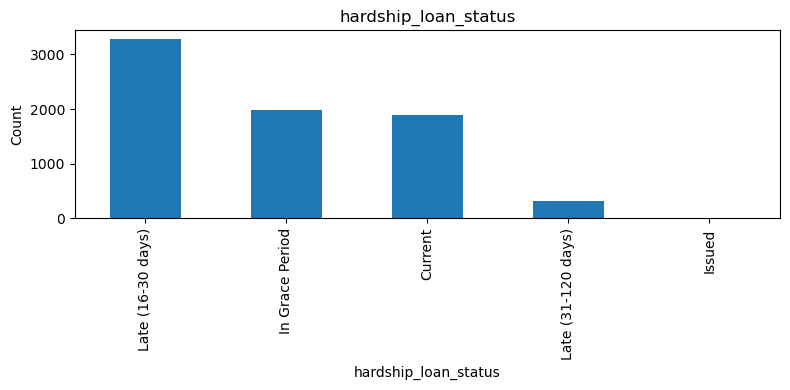

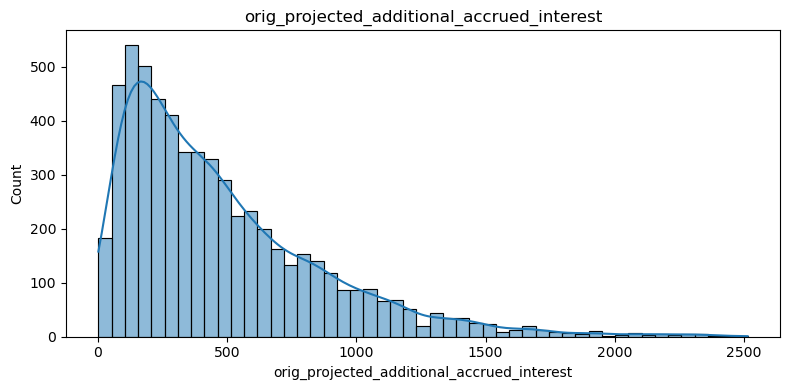

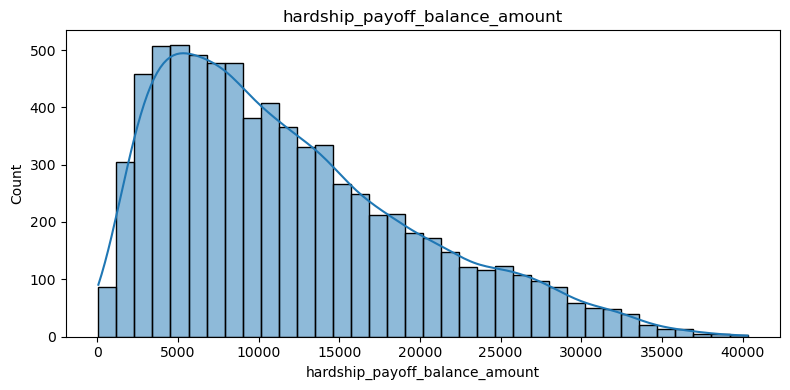

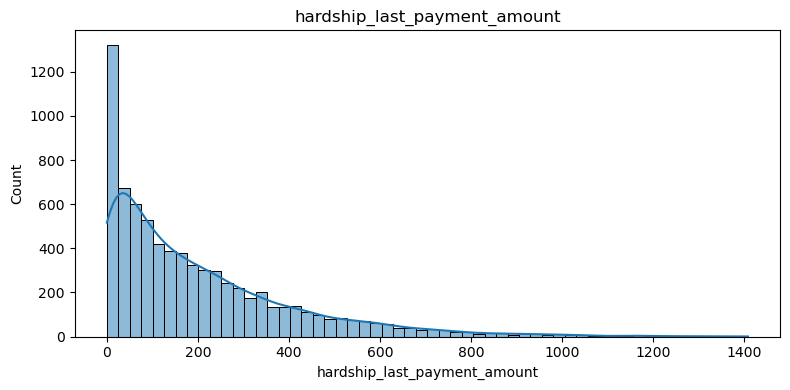

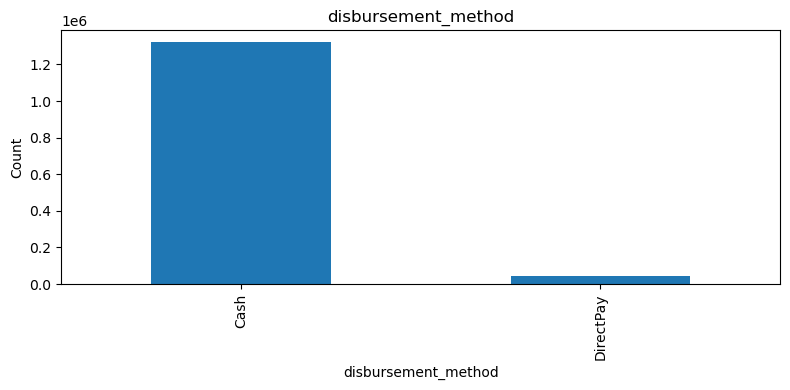

Skipping 'debt_settlement_flag_date' (too many categories: 76)


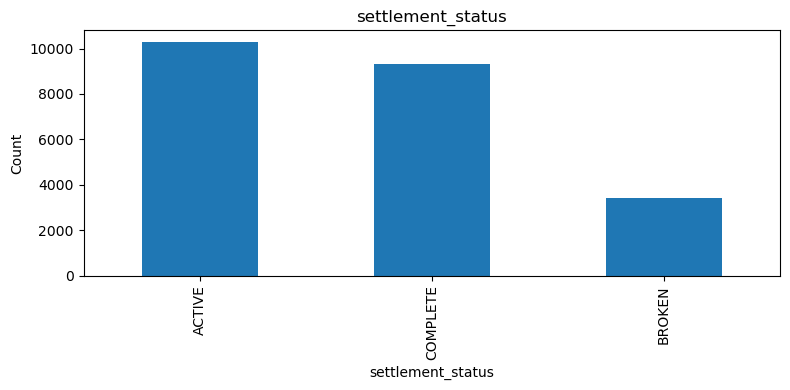

Skipping 'settlement_date' (too many categories: 83)


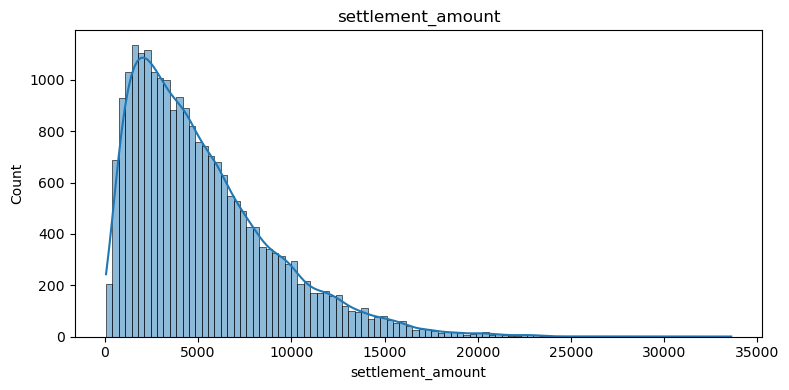

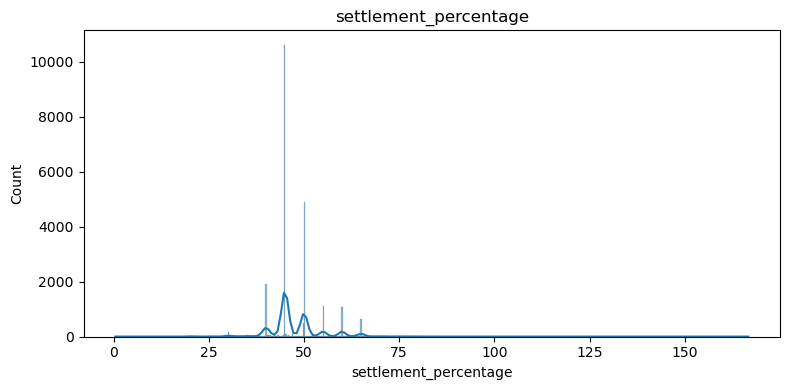

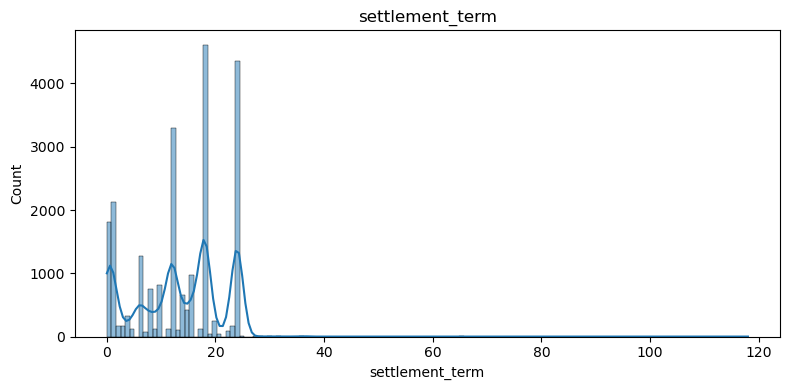

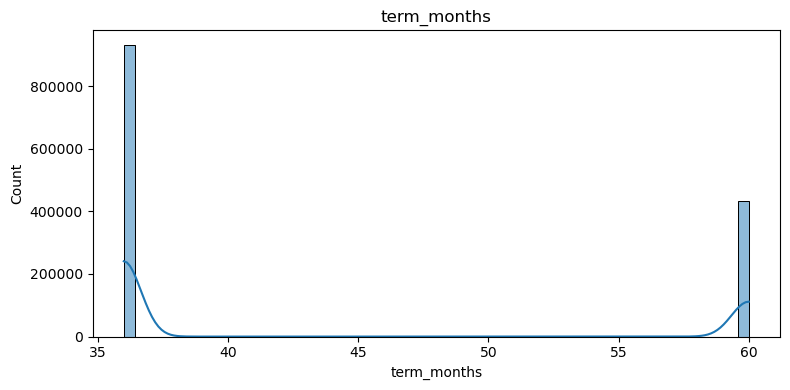

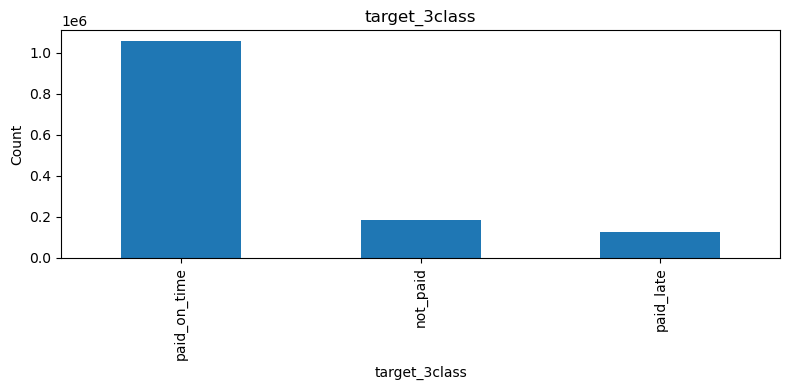

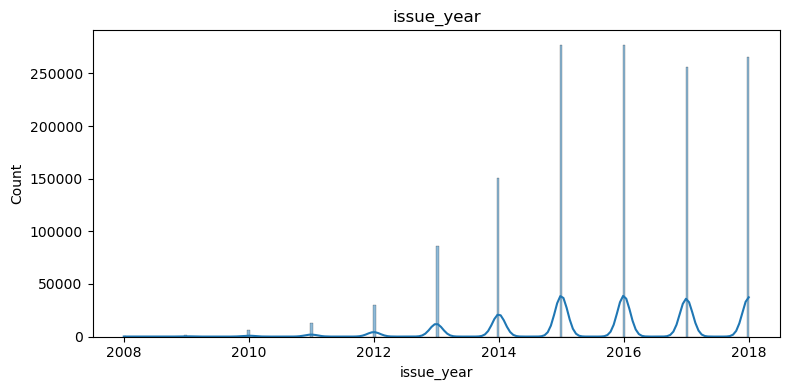

In [ ]:
for col in df_minimal_clean.columns:
    plt.figure(figsize=(8, 4))
    plt.title(col)

    # Numeric columns
    if pd.api.types.is_numeric_dtype(df_minimal_clean[col]):
        sns.histplot(df_minimal_clean[col].dropna(), kde=True)
        plt.xlabel(col)

        # Categorical or text columns
    else:
        num_unique = df_minimal_clean[col].nunique()

        if num_unique <= 15:
            df_minimal_clean[col].value_counts().plot(kind="bar")
            plt.xlabel(col)
            plt.ylabel("Count")
        else:
            print(f"Skipping '{col}' (too many categories: {num_unique})")
            plt.close()
            continue

    plt.tight_layout()
    plt.show()

Based on the plots, and with Ori's advice, we capped values that were extremely large and not plausible:

In [9]:
P99_CLIP_COLS = [
    "open_rv_12m",
    "open_rv_24m",
    "mort_acc",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "tax_liens",
    "num_tl_90g_dpd_24m",
]

In [10]:
def clip_p99(df, cols, q=0.99):
    """
    Clip values above the q-quantile (default P99) for selected columns.
    Safe: only clips columns that exist and are numeric.
    Returns a copy of df.
    """
    out = df.copy()
    applied = []

    for c in cols:
        if c not in out.columns:
            continue
        if not pd.api.types.is_numeric_dtype(out[c]):
            continue

        cap = out[c].quantile(q)
        out[c] = out[c].clip(upper=cap)
        applied.append((c, cap))

    return out

df_minimal_clean = clip_p99(df_minimal_clean, P99_CLIP_COLS, q=0.99)

### parameter tuning

We created balanced subsamples of the dataset for hyperparameter tuning because the full dataset was too large to tune efficiently within reasonable compute time.
The subsamples preserves equal representation across target classes, enabling faster iteration while keeping the optimization objective aligned with the imbalanced nature of the task.

In [11]:
def make_balanced_sample(df, N, target_col="target_3class", random_state=42):
    k = df[target_col].nunique()
    per_class = N // k

    parts = []
    for cls, g in df.groupby(target_col):
        n_take = min(per_class, len(g))
        parts.append(g.sample(n_take, random_state=random_state))

    balanced = pd.concat(parts, ignore_index=True)

    remaining = N - len(balanced)
    if remaining > 0:
        balanced = pd.concat([balanced, df.sample(remaining, random_state=random_state)], ignore_index=True)

    return balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [12]:
df_tune_20k = make_balanced_sample(df_minimal_clean, 20000)
print(df_tune_20k["target_3class"].value_counts())

X_20k = df_tune_20k.drop(columns=["target_3class"])
y_20k = df_tune_20k["target_3class"]

X_train_20k, X_test_20k, y_train_20k, y_test_20k = train_test_split(
    X_20k, y_20k, test_size=0.2, stratify=y_20k, random_state=42
)

preprocess_20k = make_preprocess(X_train_20k)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

target_3class
paid_late       6667
paid_on_time    6667
not_paid        6666
Name: count, dtype: int64
Dropped 1 high-cardinality categorical cols (> 2000 unique)


--- random forest ---

In [16]:
rf_baseline = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        n_jobs=-1
    ))
])

rf_baseline.fit(X_train_20k, y_train_20k)
pred = rf_baseline.predict(X_test_20k)

print("RF baseline test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RF baseline test f1_macro: 0.6957340562743122


In [15]:
rf_pipe_struct = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1))
])

rf_param_grid = {
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": [1, 2, 5, 10],
}

gs_struct = GridSearchCV(
    estimator=rf_pipe_struct,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs_struct.fit(X_train_20k, y_train_20k)

print("RF STRUCT best CV f1_macro:", gs_struct.best_score_)
print("RF STRUCT best params:", gs_struct.best_params_)

pred = gs_struct.best_estimator_.predict(X_test_20k)
print("RF STRUCT tuned test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.5s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.6s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.1s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.6s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=2; total time=   8.7s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   4.4s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=5; total time=   5.3s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   4.3s
[CV] END ......clf__max_depth=None, clf__min_samples_leaf=10; total time=   3.8s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=10, clf__min_samples_leaf=1; total time=   4.2s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=10, clf__min_samples_leaf=1; total time=   4.7s
[CV] END .........clf__max_depth=10, clf__min_samples_leaf=1; total time=   4.4s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=10, clf__min_samples_leaf=2; total time=   4.2s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=10, clf__min_samples_leaf=2; total time=   4.1s
[CV] END .........clf__max_depth=10, clf__min_samples_leaf=2; total time=   4.1s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=10, clf__min_samples_leaf=5; total time=   3.7s
[CV] END .........clf__max_depth=10, clf__min_samples_leaf=5; total time=   4.0s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .......clf__max_depth=None, clf__min_samples_leaf=1; total time=  20.3s
[CV] END .......clf__max_depth=None, clf__min_samples_leaf=1; total time=  20.5s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .......clf__max_depth=None, clf__min_samples_leaf=1; total time=  20.7s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=10, clf__min_samples_leaf=5; total time=   3.7s
[CV] END ........clf__max_depth=10, clf__min_samples_leaf=10; total time=   3.4s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ........clf__max_depth=10, clf__min_samples_leaf=10; total time=   3.3s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ........clf__max_depth=10, clf__min_samples_leaf=10; total time=   2.7s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=20, clf__min_samples_leaf=5; total time=   5.8s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=2; total time=   6.7s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=20, clf__min_samples_leaf=1; total time=   7.7s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=2; total time=   6.9s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=2; total time=   6.7s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=20, clf__min_samples_leaf=1; total time=   7.8s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=5; total time=   5.9s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=1; total time=   8.0s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ........clf__max_depth=20, clf__min_samples_leaf=10; total time=   3.1s
[CV] END ........clf__max_depth=20, clf__min_samples_leaf=10; total time=   3.2s
[CV] END .........clf__max_depth=20, clf__min_samples_leaf=5; total time=   4.1s
[CV] END ........clf__max_depth=20, clf__min_samples_leaf=10; total time=   3.5s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END .........clf__max_depth=30, clf__min_samples_leaf=2; total time=   8.3s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=30, clf__min_samples_leaf=5; total time=   6.4s
[CV] END .........clf__max_depth=30, clf__min_samples_leaf=5; total time=   6.6s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=30, clf__min_samples_leaf=2; total time=   8.2s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=30, clf__min_samples_leaf=2; total time=   8.6s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .........clf__max_depth=30, clf__min_samples_leaf=1; total time=  14.0s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ........clf__max_depth=30, clf__min_samples_leaf=10; total time=   4.5s
[CV] END .........clf__max_depth=30, clf__min_samples_leaf=5; total time=   5.4s
[CV] END ........clf__max_depth=30, clf__min_samples_leaf=10; total time=   4.3s
[CV] END .........clf__max_depth=30, clf__min_samples_leaf=1; total time=  14.4s
[CV] END .........clf__max_depth=30, clf__min_samples_leaf=1; total time=  14.5s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ........clf__max_depth=30, clf__min_samples_leaf=10; total time=   3.8s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RF STRUCT best CV f1_macro: 0.6870668373106809
RF STRUCT best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1}
RF STRUCT tuned test f1_macro: 0.6920557097446057


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [13]:
df_tune_120k = make_balanced_sample(df_minimal_clean, 120000)

DROP_COLS = ["id", "member_id", "url"]

X_120k = df_tune_120k.drop(columns=["target_3class"] + DROP_COLS, errors="ignore")
y_120k = df_tune_120k["target_3class"]

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

preprocess_120k = make_preprocess(X_train_120k)

Dropped 3 high-cardinality categorical cols (> 2000 unique)


In [17]:
rf_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=1
    ))
])

param_grid = {
    "clf__n_estimators": [200, 400, 700, 1000],
}

gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs.fit(X_train_120k, y_train_120k)

print("RF best CV f1_macro:", gs.best_score_)
print("RF best params:", gs.best_params_)

best_rf = gs.best_estimator_
pred = best_rf.predict(X_test_120k)
print("RF tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ..............................clf__n_estimators=200; total time=11.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ..............................clf__n_estimators=200; total time=11.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ..............................clf__n_estimators=200; total time=11.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is

[CV] END ..............................clf__n_estimators=400; total time=23.1min
[CV] END ..............................clf__n_estimators=400; total time=23.0min[CV] END ..............................clf__n_estimators=400; total time=23.0min



/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ..............................clf__n_estimators=700; total time=37.3min
[CV] END ..............................clf__n_estimators=700; total time=37.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ..............................clf__n_estimators=700; total time=33.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............................clf__n_estimators=1000; total time=43.0min
[CV] END .............................clf__n_estimators=1000; total time=43.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............................clf__n_estimators=1000; total time=36.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RF best CV f1_macro: 0.7010859400301328
RF best params: {'clf__n_estimators': 1000}


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RF tuned test f1_macro: 0.7013943968370103


checking random forest without one-hot incoding

In [18]:
# =========================================================
# 1) RF WITH OHE
# =========================================================
preprocess_with_ohe = make_preprocess(X_train_120k)

rf_with_ohe = Pipeline([
    ("preprocess", preprocess_with_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400, 
        n_jobs=-1
    ))
])

rf_with_ohe.fit(X_train_120k, y_train_120k)
pred_with_ohe = rf_with_ohe.predict(X_test_120k)

with_ohe_acc = accuracy_score(y_test_120k, pred_with_ohe)
with_ohe_f1  = f1_score(y_test_120k, pred_with_ohe, average="macro")

print("=== RF WITH OHE ===")
print("Accuracy:", with_ohe_acc)
print("Macro F1:", with_ohe_f1)
print(classification_report(y_test_120k, pred_with_ohe))


# =========================================================
# 2) RF NO OHE (numeric only, same numeric treatment)
# =========================================================
numeric_cols = X_train_120k.select_dtypes(include="number").columns.tolist()
time_cols = [c for c in numeric_cols if c.startswith("mths_since_")]
num_regular = list(set(numeric_cols) - set(time_cols))

time_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
    ("scaler", StandardScaler())
])

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

preprocess_no_ohe = ColumnTransformer(
    transformers=[
        ("time", time_pipeline, time_cols),
        ("num", numeric_pipeline, num_regular),
        # intentionally no categorical transformer
    ],
    remainder="drop"
)

rf_no_ohe = Pipeline([
    ("preprocess", preprocess_no_ohe),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

rf_no_ohe.fit(X_train_120k, y_train_120k)
pred_no_ohe = rf_no_ohe.predict(X_test_120k)

no_ohe_acc = accuracy_score(y_test_120k, pred_no_ohe)
no_ohe_f1  = f1_score(y_test_120k, pred_no_ohe, average="macro")

print("\n=== RF NO OHE (numeric only) ===")
print("Accuracy:", no_ohe_acc)
print("Macro F1:", no_ohe_f1)
print(classification_report(y_test_120k, pred_no_ohe))


# =========================================================
# 3) Quick comparison
# =========================================================
print("\n=== COMPARISON ===")
print(f"WITH OHE -> Acc: {with_ohe_acc:.4f}, MacroF1: {with_ohe_f1:.4f}")
print(f"NO OHE   -> Acc: {no_ohe_acc:.4f}, MacroF1: {no_ohe_f1:.4f}")
print(f"Delta MacroF1 (NO - WITH): {(no_ohe_f1 - with_ohe_f1):+.4f}")

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


=== RF WITH OHE ===
Accuracy: 0.7069583333333334
Macro F1: 0.7010263362584102
              precision    recall  f1-score   support

    not_paid       0.77      0.56      0.65      8000
   paid_late       0.68      0.89      0.77      8000
paid_on_time       0.69      0.67      0.68      8000

    accuracy                           0.71     24000
   macro avg       0.72      0.71      0.70     24000
weighted avg       0.72      0.71      0.70     24000



/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'url' 'member_id']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



=== RF NO OHE (numeric only) ===
Accuracy: 0.6705
Macro F1: 0.6625036739008426
              precision    recall  f1-score   support

    not_paid       0.67      0.52      0.58      8000
   paid_late       0.66      0.88      0.75      8000
paid_on_time       0.69      0.62      0.65      8000

    accuracy                           0.67     24000
   macro avg       0.67      0.67      0.66     24000
weighted avg       0.67      0.67      0.66     24000


=== COMPARISON ===
WITH OHE -> Acc: 0.7070, MacroF1: 0.7010
NO OHE   -> Acc: 0.6705, MacroF1: 0.6625
Delta MacroF1 (NO - WITH): -0.0385


--- logistic regression ---

In [20]:
lr_pipe_tuning = Pipeline([
    ("pre", preprocess_120k),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

lr_pipe_tuning.fit(X_train_120k, y_train_120k)
y_pred = lr_pipe_tuning.predict(X_test_120k)
baseline_lr_f1 = f1_score(y_test_120k, y_pred, average="macro")

print("Baseline LR Macro F1:", baseline_lr_f1)

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed

Baseline LR Macro F1: 0.7476111226357204


In [22]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_pipe_tuning = Pipeline([
    ("pre", preprocess_120k),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        random_state=42
    ))
])

logreg_param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0],
    "clf__class_weight": [None, "balanced"]
}

logreg_search = GridSearchCV(
    estimator=lr_pipe_tuning, 
    param_grid=logreg_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

logreg_search.fit(X_train_120k, y_train_120k)

print("LogReg best CV F1:", logreg_search.best_score_)
print("LogReg best params:", logreg_search.best_params_)

pred = logreg_search.best_estimator_.predict(X_test_120k)
print("LogReg tuned test F1:", f1_score(y_test_120k, pred, average="macro"))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END ................clf__C=0.01, clf__class_weight=None; total time= 1.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ................clf__C=0.01, clf__class_weight=None; total time= 1.8min
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time= 1.7min
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time= 1.7min
[CV] END ............clf__C=0.01, clf__class_weight=balanced; total time= 1.8min
[CV] END ................clf__C=0.01, clf__class_weight=None; total time= 1.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 3.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 3.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ................clf__C=0.05, clf__class_weight=None; total time= 3.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ............clf__C=0.05, clf__class_weight=balanced; total time= 3.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ............clf__C=0.05, clf__class_weight=balanced; total time= 3.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END ............clf__C=0.05, clf__class_weight=balanced; total time= 4.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.1, clf__class_weight=None; total time= 6.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.1, clf__class_weight=None; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.1, clf__class_weight=balanced; total time= 5.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.1, clf__class_weight=None; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.1, clf__class_weight=balanced; total time= 6.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.1, clf__class_weight=balanced; total time= 6.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.5, clf__class_weight=None; total time= 8.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.5, clf__class_weight=None; total time= 8.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=0.5, clf__class_weight=None; total time= 7.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.5, clf__class_weight=balanced; total time= 7.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.5, clf__class_weight=balanced; total time= 7.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=0.5, clf__class_weight=balanced; total time= 7.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=1.0, clf__class_weight=None; total time= 7.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=1.0, clf__class_weight=None; total time= 7.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .................clf__C=1.0, clf__class_weight=None; total time= 6.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=1.0, clf__class_weight=balanced; total time= 6.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=1.0, clf__class_weight=balanced; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END .............clf__C=1.0, clf__class_weight=balanced; total time= 7.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


LogReg best CV F1: 0.7503251759555192
LogReg best params: {'clf__C': 0.1, 'clf__class_weight': None}


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


LogReg tuned test F1: 0.7563080259052275


--- xgboost ---

In [23]:
y_cat = df_tune_120k["target_3class"].astype("category")
label_map = dict(enumerate(y_cat.cat.categories))
print("label_map:", label_map)

y_120k = y_cat.cat.codes

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

label_map: {0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


In [24]:
xgb_baseline = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,

        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

xgb_baseline.fit(X_train_120k, y_train_120k)
pred = xgb_baseline.predict(X_test_120k)
print("XGB baseline test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGB baseline test f1_macro: 0.7719039448704459


In [25]:
xgb_param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7, 10],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.2, 0.6],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train_120k, y_train_120k)

print("XGB best CV f1_macro:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_
pred = best_xgb.predict(X_test_120k)
print("XGB tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 2.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 2.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 2.3min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 6.7min
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 6.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 6.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.3min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.6; total time=  56.5s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.6; total time=  54.9s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.6; total time=  51.6s


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 1.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 1.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.8; total time= 3.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.8; total time= 3.0min
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.8; total time= 3.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=1.0; total time= 2.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.8; total time=12.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.8; total time=12.7min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.8; total time=12.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.6; total time= 2.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.6; total time= 2.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.01, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=800, clf__subsample=0.6; total time= 2.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 1.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 1.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 1.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.6; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.6; total time= 6.4min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=1.0; total time= 3.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.6; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=500, clf__subsample=0.8; total time= 1.5min
[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=1.0; total time= 3.6min
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=500, clf__subsample=0.8; total time= 1.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=500, clf__subsample=0.8; total time= 1.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.6, clf__learning_rate=0.01, clf__max_depth=7, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=1.0; total time= 3.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 1.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=1.0; total time= 8.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=1.0; total time= 9.2min
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.1min
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=3, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.6; total time= 2.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=1.0; total time= 8.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 1.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0.2, clf__learning_rate=0.1, clf__max_depth=3, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 1.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.6min
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=5, clf__n_estimators=300, clf__subsample=0.6; total time= 1.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=0.6; total time= 1.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=0.6; total time= 1.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.8, clf__gamma=0, clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=300, clf__subsample=0.6; total time= 1.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 4.6min
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 4.6min
[CV] END clf__colsample_bytree=1.0, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=500, clf__subsample=0.6; total time= 4.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.8; total time= 3.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.8; total time= 3.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.1, clf__max_depth=10, clf__min_child_weight=3, clf__n_estimators=300, clf__subsample=0.8; total time= 3.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGB best CV f1_macro: 0.7714627705397413
XGB best params: {'clf__subsample': 1.0, 'clf__n_estimators': 500, 'clf__min_child_weight': 5, 'clf__max_depth': 10, 'clf__learning_rate': 0.05, 'clf__gamma': 0.6, 'clf__colsample_bytree': 0.6}


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGB tuned test f1_macro: 0.7771134399387968


In [ ]:
xgb_param_refined = {
    "clf__n_estimators": [400, 500, 650, 800],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__max_depth": [8, 10, 12],
    "clf__min_child_weight": [3, 5, 7],
    "clf__gamma": [0.2, 0.6, 1.0],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.5, 0.6, 0.7],
}


xgb_search_refined = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_refined,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search_refined.fit(X_train_120k, y_train_120k)

print("XGB refined best CV f1_macro:", xgb_search_refined.best_score_)
print("XGB refined best params:", xgb_search_refined.best_params_)

best_xgb_refined = xgb_search_refined.best_estimator_
pred = best_xgb_refined.predict(X_test_120k)
print("XGB refined tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))


Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 7.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 7.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is

[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 8.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 8.3min
[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=650, clf__subsample=1.0; total time= 8.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 4.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 4.1min
[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 4.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 5.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=650, clf__subsample=0.8; total time= 5.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time=16.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time=16.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=12, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time=16.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=650, clf__subsample=0.8; total time= 6.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=650, clf__subsample=0.8; total time= 5.9min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.8; total time= 7.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.8; total time= 7.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=0.8; total time= 7.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time= 5.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time= 5.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=7, clf__n_estimators=800, clf__subsample=0.9; total time= 5.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 5.6min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 5.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.2, clf__learning_rate=0.07, clf__max_depth=10, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=1.0; total time= 6.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time= 6.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.6, clf__learning_rate=0.03, clf__max_depth=8, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time= 6.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.9; total time= 6.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.9; total time= 6.3min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time=15.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time=16.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=650, clf__subsample=0.8; total time=15.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=800, clf__subsample=0.9; total time= 5.8min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=10, clf__min_child_weight=7, clf__n_estimators=500, clf__subsample=1.0; total time= 7.5min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=0.9; total time= 3.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=0.9; total time= 3.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=1.0; total time=19.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=1.0; total time=19.0min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=10, clf__min_child_weight=7, clf__n_estimators=500, clf__subsample=1.0; total time= 7.4min
[CV] END clf__colsample_bytree=0.5, clf__gamma=1.0, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=400, clf__subsample=0.9; total time= 3.1min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.2, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_weight=3, clf__n_estimators=800, clf__subsample=1.0; total time=18.2min
[CV] END clf__colsample_bytree=0.6, clf__gamma=1.0, clf__learning_rate=0.03, clf__max_depth=10, clf__min_child_weight=7, clf__n_estimators=500, clf__subsample=1.0; total time= 7.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 3.7min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 3.4min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__colsample_bytree=0.7, clf__gamma=0.6, clf__learning_rate=0.05, clf__max_depth=8, clf__min_child_weight=5, clf__n_estimators=500, clf__subsample=0.8; total time= 3.2min


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGB refined best CV f1_macro: 0.7716291626959184
XGB refined best params: {'clf__subsample': 1.0, 'clf__n_estimators': 800, 'clf__min_child_weight': 3, 'clf__max_depth': 12, 'clf__learning_rate': 0.05, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.7}


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGB refined tuned test f1_macro: 0.7785214584475607


In [14]:
final_xgb_params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 10,
    "min_child_weight": 5,
    "gamma": 0.6,
    "subsample": 1.0,
    "colsample_bytree": 0.6,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": 1,
}

Calibration curve


In [15]:
# Fitting XGBoost with the tuned hyperparameters
X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"]

# Convert target for XGBoost
y = y.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# Build preprocessing based only on the feature matrix
preprocess = make_preprocess(X_train)

Dropped 3 high-cardinality categorical cols (> 2000 unique)


In [ ]:
# check 1: preprocessing on a small subset
Xt_small = preprocess.fit_transform(X_train.iloc[:5000])
print("Xt_small type:", type(Xt_small))
print("Xt_small shape:", Xt_small.shape)

# check 2: preprocessing on full training set
Xt = preprocess.fit_transform(X_train)
print("Xt shape:", Xt.shape)
print("nnz (if sparse):", getattr(Xt, "nnz", None))


Xt_small type: <class 'scipy.sparse._csr.csr_matrix'>
Xt_small shape: (5000, 1903)
Xt shape: (1091420, 2993)
nnz (if sparse): 220466840


In [16]:
# Parameters according to the tuning
model = XGBClassifier(**final_xgb_params)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# Fit
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [21]:
y_cat = df_minimal_clean["target_3class"].astype("category")
code_to_label = dict(enumerate(y_cat.cat.categories))

y = y_cat.cat.codes
print(code_to_label)

{0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


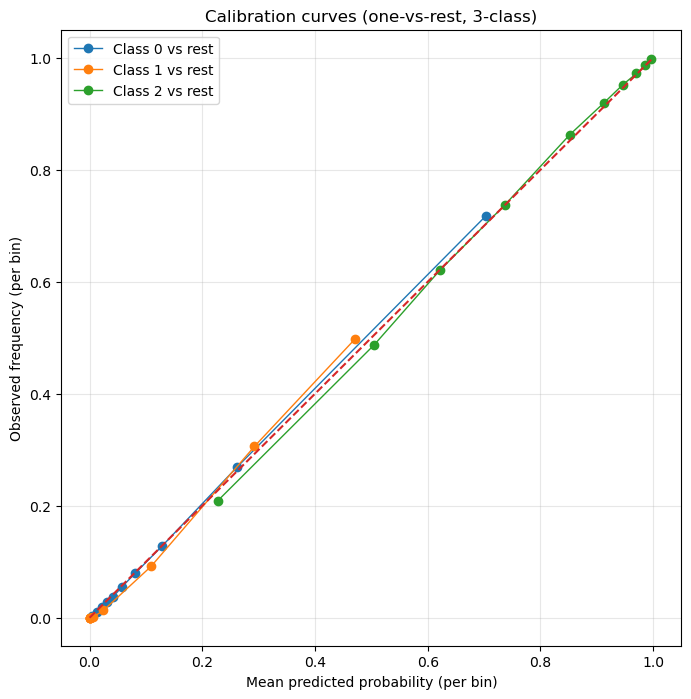

In [19]:
def plot_multiclass_calibration_curves(fitted_pipe, X, y, n_bins=10, strategy="quantile"):
    """
    Multiclass calibration via one-vs-rest curves.
    For each class k: compare predicted P(Y=k) vs observed frequency of Y=k.
    """
    proba = fitted_pipe.predict_proba(X)

    plt.figure(figsize=(8, 8))

    for k in range(3):  # because the labels are 0/1/2
        y_bin = (y == k).astype(int)  # 1 if class k, else 0

        frac_pos, mean_pred = calibration_curve(
            y_bin,
            proba[:, k],
            n_bins=n_bins,
            strategy=strategy
        )

        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=f"Class {k} vs rest")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability (per bin)")
    plt.ylabel("Observed frequency (per bin)")
    plt.title("Calibration curves (one-vs-rest, 3-class)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_multiclass_calibration_curves(pipe, X_test, y_test)

### Threshold Tuning ###

In [22]:
y_pred_base = pipe.predict(X_test)

print("BASE Macro F1:", f1_score(y_test, y_pred_base, average="macro"))
print(classification_report(y_test, y_pred_base, target_names=[code_to_label[c] for c in pipe.named_steps["model"].classes_]))

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


BASE Macro F1: 0.6168719113619888
              precision    recall  f1-score   support

    not_paid       0.78      0.46      0.58     36717
   paid_late       0.58      0.27      0.37     24820
paid_on_time       0.85      0.96      0.90    211318

    accuracy                           0.83    272855
   macro avg       0.74      0.56      0.62    272855
weighted avg       0.81      0.83      0.81    272855



In [23]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [24]:
preprocess_tr = make_preprocess(X_tr)

pipe_tr = Pipeline([
    ("pre", preprocess_tr),
    ("model", XGBClassifier(**final_xgb_params))
])

pipe_tr.fit(X_tr, y_tr)

# Validation probabilities ONCE
proba_val = pipe_tr.predict_proba(X_val)

classes = list(pipe_tr.named_steps["model"].classes_)
print("Class order:", classes)

Dropped 3 high-cardinality categorical cols (> 2000 unique)


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Class order: [0, 1, 2]


In [25]:
# ============================================================
# Custom prediction with class-specific thresholds
# ============================================================
def predict_with_thresholds(proba, thresholds):
    """
    proba: array (n_samples, n_classes)
    thresholds: dict {class_index: threshold}

    Strategy:
    - if a class probability exceeds its threshold -> candidate
    - if multiple candidates -> take highest probability among them
    - if none -> fallback to argmax
    """
    preds = []
    for p in proba:
        candidates = [k for k, t in thresholds.items() if p[k] >= t]

        if len(candidates) == 1:
            preds.append(candidates[0])
        elif len(candidates) > 1:
            preds.append(max(candidates, key=lambda k: p[k]))
        else:
            preds.append(int(np.argmax(p)))

    return np.array(preds)

In [26]:
#Threshold grid search (NO model retraining here)
grid_not_paid    = np.arange(0.24, 0.29, 0.005)
grid_paid_late   = np.arange(0.27, 0.32, 0.005)
grid_paid_ontime = np.arange(0.63, 0.70, 0.01)

In [68]:
best_score = -1
best_thresholds = None

# Iterate over all threshold combinations
for t0, t1, t2 in product(grid_not_paid, grid_paid_late, grid_paid_ontime):
    thresholds = {0: t0, 1: t1, 2: t2}
    preds_val = predict_with_thresholds(proba_val, thresholds)
    score = f1_score(y_val, preds_val, average="macro")

    if score > best_score:
        best_score = score
        best_thresholds = thresholds

print("\nBEST VAL Macro F1:", best_score)
print("BEST VAL thresholds:", best_thresholds)


# See VAL report at best thresholds
pred_val_best = predict_with_thresholds(proba_val, best_thresholds)
print("\n===== VAL @ BEST THRESHOLDS =====")
print("VAL Accuracy:", accuracy_score(y_val, pred_val_best))
print("VAL Macro F1:", f1_score(y_val, pred_val_best, average="macro"))
print(confusion_matrix(y_val, pred_val_best, labels=classes))
print(classification_report(y_val, pred_val_best, digits=4))


BEST VAL Macro F1: 0.6867136872601947
BEST VAL thresholds: {0: 0.28500000000000003, 1: 0.28500000000000003, 2: 0.66}

===== VAL @ BEST THRESHOLDS =====
VAL Accuracy: 0.8087949643583588
VAL Macro F1: 0.6867136872601947
[[ 17306   1810  10257]
 [   544  14549   4763]
 [  8395  15968 144692]]
              precision    recall  f1-score   support

           0     0.6594    0.5892    0.6223     29373
           1     0.4501    0.7327    0.5576     19856
           2     0.9060    0.8559    0.8802    169055

    accuracy                         0.8088    218284
   macro avg     0.6718    0.7259    0.6867    218284
weighted avg     0.8313    0.8088    0.8162    218284



In [27]:
best_thresholds = {0: 0.285, 1: 0.285, 2: 0.66}

In [28]:
proba_test = pipe.predict_proba(X_test)
y_pred_test_thresh = predict_with_thresholds(proba_test, best_thresholds)

print("\n===== TEST @ BEST THRESHOLDS =====")
print("TEST Accuracy:", accuracy_score(y_test, y_pred_test_thresh))
print("TEST Macro F1:", f1_score(y_test, y_pred_test_thresh, average="macro"))
print(confusion_matrix(y_test, y_pred_test_thresh, labels=list(pipe.named_steps["model"].classes_)))
print(classification_report(y_test, y_pred_test_thresh, digits=4))

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



===== TEST @ BEST THRESHOLDS =====
TEST Accuracy: 0.8080702204467575
TEST Macro F1: 0.6852674538912881
[[ 21564   2318  12835]
 [   654  18094   6072]
 [ 10493  19997 180828]]
              precision    recall  f1-score   support

           0     0.6592    0.5873    0.6212     36717
           1     0.4478    0.7290    0.5548     24820
           2     0.9053    0.8557    0.8798    211318

    accuracy                         0.8081    272855
   macro avg     0.6708    0.7240    0.6853    272855
weighted avg     0.8306    0.8081    0.8155    272855



### Feature Importance ###

In [71]:
#top 5 XGB features
def top5_xgb_features(pipeline, preprocess_step="pre", model_step="model"):
    """
    Top 5 most important BASE features from a fitted XGBoost pipeline.
    Works with ColumnTransformer + OneHotEncoder.
    """

    pre = pipeline.named_steps[preprocess_step]
    model = pipeline.named_steps[model_step]

    # Expanded feature names after preprocessing
    feature_names = pre.get_feature_names_out()

    # Importances aligned with feature_names
    importances = model.feature_importances_

    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi[fi["importance"] > 0].copy()

    # Pull original categorical columns used in ColumnTransformer block named "cat"
    cat_cols = []
    for name, _, cols in pre.transformers_:
        if name == "cat":
            cat_cols = list(cols)
            break
    cat_cols = sorted([str(c) for c in cat_cols], key=len, reverse=True)

    # Map expanded features back to base column names
    def to_base(f):
        if f.startswith("num__"):
            return f.replace("num__", "", 1)
        if f.startswith("time__"):
            return f.replace("time__", "", 1)
        if f.startswith("cat__"):
            rest = f.replace("cat__", "", 1)
            for c in cat_cols:
                if rest == c or rest.startswith(c + "_"):
                    return c
            return rest
        return f

    fi["base_feature"] = fi["feature"].astype(str).apply(to_base)

    # Aggregate importances to base features
    agg = (
        fi.groupby("base_feature", as_index=False)["importance"]
          .sum()
          .sort_values("importance", ascending=False)
          .reset_index(drop=True)
    )

    # Percent (for readability)
    agg["importance_pct"] = agg["importance"] / agg["importance"].sum() * 100

    return agg.head(5)


In [72]:
top5 = top5_xgb_features(pipe, preprocess_step="pre", model_step="model")
print(top5)

                   base_feature  importance  importance_pct
0            last_credit_pull_d    0.182335       18.233461
1                      zip_code    0.117668       11.766843
2     debt_settlement_flag_date    0.112667       11.266703
3  missingindicator_open_act_il    0.098775        9.877520
4              earliest_cr_line    0.078630        7.863037


### Top 5 features model

In [73]:
TOP5_BASE_FEATURES = [
    "last_credit_pull_d",
    "zip_code",
    "debt_settlement_flag_date",
    "open_act_il",
    "earliest_cr_line",
]

In [74]:
# 2) Preprocessing for Top-5 only
def make_preprocess_top5(df):
    # Determine categorical vs numeric based on TRAIN dtypes
    cat_cols = [c for c in TOP5_BASE_FEATURES if df[c].dtype == "object"]
    num_cols = [c for c in TOP5_BASE_FEATURES if df[c].dtype != "object"]

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ], remainder="drop")



In [ ]:
# Use ONLY top-5 features
X_top5 = df_minimal_clean[TOP5_BASE_FEATURES].copy()
y_top5 = df_minimal_clean["target_3class"].astype("category").cat.codes

X_train_top5, X_test_top5, y_train_top5, y_test_top5 = train_test_split(
    X_top5, y_top5, test_size=0.2, stratify=y_top5, random_state=42
)


# Build preprocess on train only
preprocess_top5 = make_preprocess_top5(X_train_top5)

# Train model
xgb_top5 = Pipeline([
    ("preprocess", preprocess_top5),
    ("clf", XGBClassifier(**final_xgb_params))
])

xgb_top5.fit(X_train_top5, y_train_top5)

# Evaluate on TEST
y_pred_test_top5 = xgb_top5.predict(X_test_top5)

print("XGB TOP-5 (rough check)")
print("Accuracy:", accuracy_score(y_test_top5, y_pred_test_top5))
print("Macro F1 :", f1_score(y_test_top5, y_pred_test_top5, average="macro"))
print(classification_report(y_test_top5, y_pred_test_top5, digits=4))

XGB TOP-5 (rough check)
Accuracy: 0.8119367429587143
Macro F1 : 0.4584537758766149
              precision    recall  f1-score   support

           0     0.8154    0.3432    0.4831     36717
           1     0.2571    0.0004    0.0007     24820
           2     0.8118    0.9887    0.8916    211318

    accuracy                         0.8119    272855
   macro avg     0.6281    0.4441    0.4585    272855
weighted avg     0.7618    0.8119    0.7556    272855



### Confidence intervals

In [29]:
# ---------------------------
# Bootstrap CI function
# ---------------------------
def bootstrap_ci_final_model(y_true, y_pred, n_boot=2000, random_state=42):
    """
    95% bootstrap confidence intervals for Accuracy and Macro-F1
    (fixed predictions, resample TEST set with replacement).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rng = np.random.default_rng(random_state)
    n = len(y_true)

    acc_scores = np.empty(n_boot)
    f1_scores  = np.empty(n_boot)

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_pred[idx]
        acc_scores[_] = accuracy_score(yt, yp)
        f1_scores[_]  = f1_score(yt, yp, average="macro")

    acc_low, acc_high = np.percentile(acc_scores, [2.5, 97.5])
    f1_low,  f1_high  = np.percentile(f1_scores,  [2.5, 97.5])

    return {
        "accuracy_mean": float(acc_scores.mean()),
        "accuracy_ci_low": float(acc_low),
        "accuracy_ci_high": float(acc_high),
        "macro_f1_mean": float(f1_scores.mean()),
        "macro_f1_ci_low": float(f1_low),
        "macro_f1_ci_high": float(f1_high),
    }

In [30]:
# ---------------------------
# FINAL predictions on TEST (WITH thresholds)
# assumes you already have: best_thresholds, predict_with_thresholds, and fitted pipe
# ---------------------------
proba_test = pipe.predict_proba(X_test)
y_pred_test_thresh = predict_with_thresholds(proba_test, best_thresholds)

print("FINAL MODEL (XGB + thresholds) - TEST metrics")
print("Accuracy:", accuracy_score(y_test, y_pred_test_thresh))
print("Macro F1 :", f1_score(y_test, y_pred_test_thresh, average="macro"))
print(classification_report(y_test, y_pred_test_thresh, digits=4))


# ---------------------------
# Bootstrap 95% CI on TEST
# ---------------------------
ci = bootstrap_ci_final_model(y_test, y_pred_test_thresh, n_boot=2000, random_state=42)

print("\nFINAL MODEL (XGB + thresholds) - 95% Bootstrap Confidence Intervals")
print(f"Accuracy : {ci['accuracy_mean']:.4f} [{ci['accuracy_ci_low']:.4f}, {ci['accuracy_ci_high']:.4f}]")
print(f"Macro F1 : {ci['macro_f1_mean']:.4f} [{ci['macro_f1_ci_low']:.4f}, {ci['macro_f1_ci_high']:.4f}]")

/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


FINAL MODEL (XGB + thresholds) - TEST metrics
Accuracy: 0.8080702204467575
Macro F1 : 0.6852674538912881
              precision    recall  f1-score   support

           0     0.6592    0.5873    0.6212     36717
           1     0.4478    0.7290    0.5548     24820
           2     0.9053    0.8557    0.8798    211318

    accuracy                         0.8081    272855
   macro avg     0.6708    0.7240    0.6853    272855
weighted avg     0.8306    0.8081    0.8155    272855


FINAL MODEL (XGB + thresholds) - 95% Bootstrap Confidence Intervals
Accuracy : 0.8081 [0.8066, 0.8095]
Macro F1 : 0.6853 [0.6831, 0.6876]


### Evaluation ###

Dropped 3 high-cardinality categorical cols (> 2000 unique)


/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/nhrqyyb/anaconda3/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['id' 'member_id' 'url']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



EVALUATION — FROZEN TEST SET ONLY (10%)
Classes (order): ['not_paid', 'paid_late', 'paid_on_time']
Test size: 151,587

accuracy              : 0.831958
balanced_accuracy     : 0.569182
f1_macro              : 0.622094
f1_weighted           : 0.810899
roc_auc_ovr_macro     : 0.903826
pr_auc_macro          : 0.730578
log_loss              : 0.392625
brier_multiclass      : 0.232441

Confusion Matrix (counts):
              not_paid  paid_late  paid_on_time
not_paid          9547        373         10478
paid_late          239       3853          9697
paid_on_time      2439       2247        112714

Confusion Matrix (row-normalized):
              not_paid  paid_late  paid_on_time
not_paid        0.4680     0.0183        0.5137
paid_late       0.0173     0.2794        0.7032
paid_on_time    0.0208     0.0191        0.9601

Classification Report:
              precision    recall  f1-score   support

    not_paid     0.7809    0.4680    0.5853     20398
   paid_late     0.5952    0.2794  

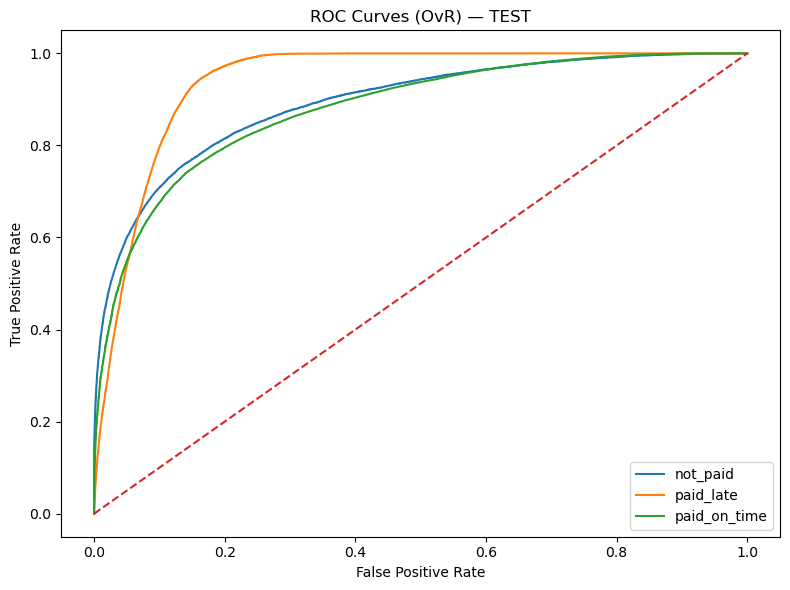

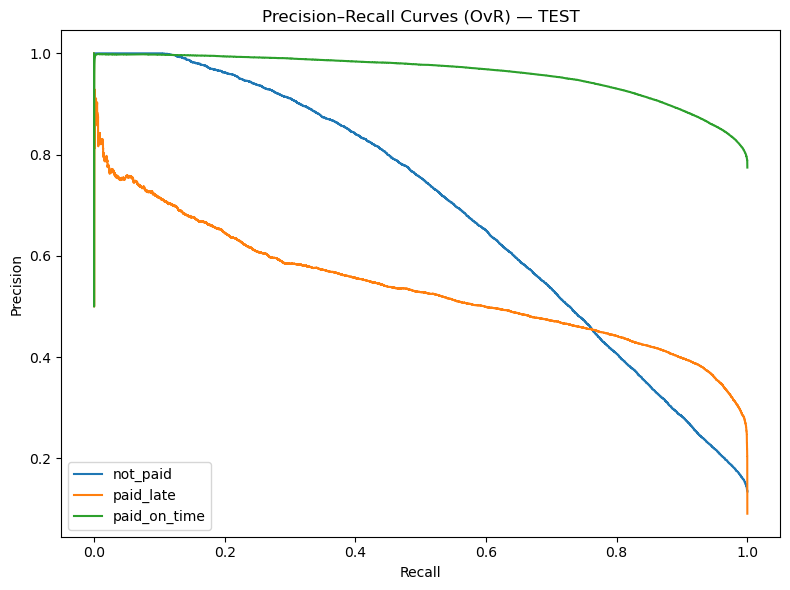

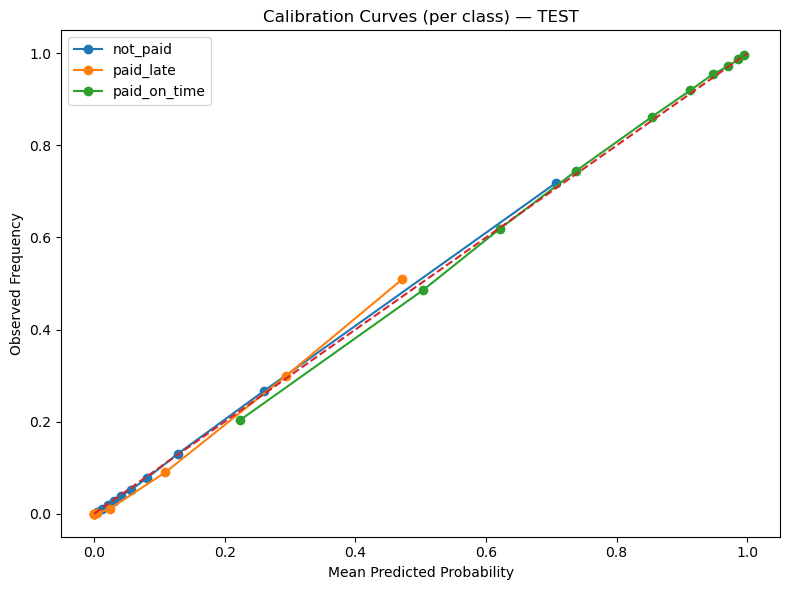

In [31]:
# Prepare DEV (train) and TEST (frozen) matrices
X_dev = df_minimal_clean_train.drop(columns=["target_3class"]).copy()
y_dev_cat = df_minimal_clean_train["target_3class"].astype("category")
class_names = list(y_dev_cat.cat.categories)
y_dev = y_dev_cat.cat.codes.to_numpy()

X_test = df_test.drop(columns=["target_3class"]).copy()
y_test_cat = pd.Categorical(df_test["target_3class"], categories=class_names)
y_test = pd.Series(y_test_cat).cat.codes.to_numpy()

K = len(class_names)

# Fit final model once on ALL dev (no extra splits)
preprocess = make_preprocess(X_dev)
model = XGBClassifier(**final_xgb_params)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

pipe.fit(X_dev, y_dev)

# Evaluate on test only
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=list(range(K)))
y_test_oh = np.eye(K)[y_test]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
    "log_loss": log_loss(y_test, y_proba, labels=list(range(K))),
    "brier_multiclass": float(np.mean(np.sum((y_proba - y_test_oh) ** 2, axis=1))),
    "roc_auc_ovr_macro": roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro"),
    "pr_auc_macro": average_precision_score(y_test_bin, y_proba, average="macro"),
}

cm = confusion_matrix(y_test, y_pred, labels=list(range(K)))
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

print("\n============================================================")
print("EVALUATION — FROZEN TEST SET ONLY (10%)")
print("============================================================")
print(f"Classes (order): {class_names}")
print(f"Test size: {len(df_test):,}\n")

for k in [
    "accuracy", "balanced_accuracy",
    "f1_macro", "f1_weighted",
    "roc_auc_ovr_macro", "pr_auc_macro",
    "log_loss", "brier_multiclass"
]:
    print(f"{k:22s}: {metrics[k]:.6f}")

print("\nConfusion Matrix (counts):")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

print("\nConfusion Matrix (row-normalized):")
print(pd.DataFrame(cm_norm, index=class_names, columns=class_names).round(4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

# -----------------------
# 4) Plots: ROC, PR, Calibration (TEST)
# -----------------------
plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (OvR) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, name in enumerate(class_names):
    frac_pos, mean_pred = calibration_curve(
        y_test_bin[:, i], y_proba[:, i],
        n_bins=10, strategy="quantile"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curves (per class) — TEST")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# -----------------------
# Per-class ROC-AUC and PR-AUC (OvR) table
# -----------------------
roc_auc_per_class = {}
pr_auc_per_class = {}

for i, name in enumerate(class_names):
    roc_auc_per_class[name] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    pr_auc_per_class[name] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

auc_table = (
    pd.DataFrame({
        "ROC-AUC (OvR)": roc_auc_per_class,
        "PR-AUC / AvgPrecision (OvR)": pr_auc_per_class
    })
    .sort_values("PR-AUC / AvgPrecision (OvR)", ascending=False)
)

print("\nPer-class AUC table (TEST):")
print(auc_table.round(4))

print("\nMacro averages (already in your metrics dict):")
print(f"roc_auc_ovr_macro: {metrics['roc_auc_ovr_macro']:.4f}")
print(f"pr_auc_macro     : {metrics['pr_auc_macro']:.4f}")



Per-class AUC table (TEST):
              ROC-AUC (OvR)  PR-AUC / AvgPrecision (OvR)
paid_on_time         0.8797                       0.9598
not_paid             0.8916                       0.6923
paid_late            0.9402                       0.5397

Macro averages (already in your metrics dict):
roc_auc_ovr_macro: 0.9038
pr_auc_macro     : 0.7306


### bad loaners features ###

In [34]:
import pandas as pd
import numpy as np

BAD_LABELS = ["not_paid"] 
TARGET_COL = "target_3class"

df = df_minimal_clean.copy()

df["is_bad"] = df[TARGET_COL].isin(BAD_LABELS)

# -------- Numeric summary (median + missing rate) ----------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["is_bad"]]

num_summary = []
for c in num_cols:
    bad = df.loc[df["is_bad"], c]
    good = df.loc[~df["is_bad"], c]
    num_summary.append({
        "feature": c,
        "bad_median": float(bad.median()),
        "good_median": float(good.median()),
        "median_diff": float(bad.median() - good.median()),
        "bad_missing%": float(bad.isna().mean() * 100),
        "good_missing%": float(good.isna().mean() * 100),
        "missing_diff": float((bad.isna().mean() - good.isna().mean()) * 100),
    })

num_summary = pd.DataFrame(num_summary)
num_summary = num_summary.sort_values(["median_diff"], key=lambda s: s.abs(), ascending=False)

print("Top numeric differences (bad vs good):")
display(num_summary.head(15))

# -------- Categorical uplift (top values where bad-rate is high) ----------
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in [TARGET_COL]]

cat_rows = []
for c in cat_cols:
    tmp = (
        df.groupby(c)["is_bad"]
          .agg(["mean", "count"])
          .rename(columns={"mean": "bad_rate", "count": "n"})
          .reset_index()
    )
    tmp = tmp[tmp["n"] >= 200].sort_values("bad_rate", ascending=False).head(10)  # מינימום דגימות
    tmp["feature"] = c
    cat_rows.append(tmp)

if cat_rows:
    cat_summary = pd.concat(cat_rows, ignore_index=True)[["feature", c, "bad_rate", "n"]]
    print("Top categorical segments with highest bad_rate:")
    display(cat_summary.head(30))
else:
    print("No categorical columns found.")


Top numeric differences (bad vs good):


,feature,bad_median,good_median,median_diff,bad_missing%,good_missing%,missing_diff
77,tot_hi_cred_lim,85867.5,116462.0,-30594.5,3.351618,2.645991,0.705627
28,tot_cur_bal,60327.0,82719.0,-22392.0,3.351618,2.645991,0.705627
24,annual_inc_joint,96000.0,110000.0,-14000.0,97.943709,94.531089,3.412621
9,annual_inc,60000.0,67000.0,-7000.0,0.000000,0.000000,0.000000
40,total_rev_hi_lim,21900.0,25300.0,-3400.0,3.351618,2.645991,0.705627
81,revol_bal_joint,24327.0,27721.0,-3394.0,98.621877,95.184180,3.437697
79,total_bc_limit,13000.0,16100.0,-3100.0,2.177217,1.879745,0.297472
45,avg_cur_bal,5721.0,7722.0,-2001.0,3.354341,2.649633,0.704708
46,bc_open_to_buy,3400.0,5081.0,-1681.0,3.341268,3.095642,0.245626
98,settlement_amount,4387.5,3168.5,1219.0,87.823491,99.942407,-12.118915


Top categorical segments with highest bad_rate:


,feature,settlement_date,bad_rate,n
0,grade,NaN,0.378823,10039
1,grade,NaN,0.351169,33696
2,grade,NaN,0.273988,102866
3,grade,NaN,0.193961,224690
4,grade,NaN,0.137594,419248
5,grade,NaN,0.083237,375204
6,grade,NaN,0.036594,198532
7,sub_grade,NaN,0.403419,1755
8,sub_grade,NaN,0.396081,1429
9,sub_grade,NaN,0.395935,2263
